In [ ]:
#Install necessary libraries
!pip install pmdarima
!pip install workalendar
!pip install prophet
!pip install -q --upgrade linear-tree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
#Import neccessary libraries
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging
import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

In [ ]:
#Import the csv file
df = pd.read_csv("Historic Demand 2009 to 2023.csv")

In [ ]:
# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

In [ ]:
#Display 7 random samples from the dataset
df.sample(n=7)

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
137044     26-OCT-2016                  7  23396  27076                 21566   
150902     10-AUG-2017                 41  30775  31289                 28319   
212713     18-FEB-2021                 26  33031  33851                 30634   
104143     10-DEC-2014                 32  45044  46053                 40804   
169745     07-SEP-2018                 20  29422  30334                 26057   
104514     18-DEC-2014                 19  41111  41694                 37422   
54987      20-FEB-2012                 28  45765  48202                 41587   

        embedded_wind_generation  embedded_wind_capacity  \
137044                      1120                    4932   
150902                       914                    5305   
212713                      3066                    6527   
104143                      2646                    4039   
169745                      1703                    5911   
104514                      1902                    4039   
54987                       1313                    1950   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
137044                          0                    11433            0   
150902                        331                    12372            0   
212713                       3950                    13080            0   
104143                         46                     5931            0   
169745                       4140                    13052          471   
104514                        123                     5954          117   
54987                         201                     1367            0   

        pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
137044                  1526     -1654          0           911         297   
150902                    11      1999          0          1011         247   
212713                    14      1947       -206           686         109   
104143                    21      1275          0           999         -25   
169745                     7       997          0           950        -404   
104514                    15      1996          0           711         -84   
54987                     10     -1531          0           994        -296   

        east_west_flow  nemo_flow  nsl_flow  eleclink_flow  
137044               0          0       NaN            NaN  
150902             375          0       NaN            NaN  
212713               0        786       0.0            0.0  
104143            -363          0       NaN            NaN  
169745            -472          0       NaN            NaN  
104514              -1          0       NaN            NaN  
54987                0          0       NaN            NaN

In [ ]:
# Convert the date column to datetime
df['settlement_date'] = pd.to_datetime(df['settlement_date'], errors='coerce')  # 'coerce' handles invalid dates

In [ ]:
df.sample(n=10)

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
141424      2017-01-25                 17  43587  45837                 40686   
20764       2010-03-09                 29  47004  49601                 42618   
226982      2021-12-12                 39  34444  36208                 32182   
153260      2017-09-28                 47  25557  26071                 23500   
241136      2022-10-03                 35  30142  33807                 28421   
204750      2020-09-05                 33  22489  22997                 20441   
212214      2021-02-08                  7  24473  25910                 22158   
159756      2018-02-11                 13  23872  25836                 21718   
96499       2014-07-04                 22  34799  35837                 32022   
23683       2010-05-09                 22  35213  36067                 31951   

        embedded_wind_generation  embedded_wind_capacity  \
141424                      1926                    4781   
20764                        238                    1829   
226982                      2971                    6527   
153260                      1662                    5305   
241136                      2264                    6545   
204750                      2072                    6527   
212214                      2532                    6527   
159756                      3278                    5779   
96499                       1812                    3575   
23683                        210                    2236   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
141424                        104                    11503          134   
20764                           0                        0            0   
226982                          0                    13080            0   
153260                          0                    12372            0   
241136                       1075                    13861            0   
204750                       3620                    13080            0   
212214                          0                    13080            0   
159756                          0                    12916            0   
96499                        2440                     4959            0   
23683                           1                       22            0   

        pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
141424                    16     -1023          0          -745          51   
20764                      7     -1538          0             0        -452   
226982                     7      -577       -580           996         273   
153260                    14       811          0           746         296   
241136                     2         0      -1016          -354         399   
204750                     8      1386          0             0         133   
212214                   801      1236        -36             0         401   
159756                  1364      1598          0           780         191   
96499                     14      1996          0           999        -120   
23683                      5      1852          0             0        -349   

        east_west_flow  nemo_flow  nsl_flow  eleclink_flow  
141424             166          0       NaN            NaN  
20764                0          0       NaN            NaN  
226982             482       1019     693.0            0.0  
153260             432          0       NaN            NaN  
241136             504       -451    -319.0        -1023.0  
204750              12        893       0.0            0.0  
212214             405        706       0.0            0.0  
159756             432          0       NaN            NaN  
96499             -404          0       NaN            NaN  
23683                0          0       NaN            NaN

In [ ]:
#Get a summary of the dataset
df.describe()

settlement_period             nd            tsd  england_wales_demand  \
count      252958.000000  252958.000000  252958.000000         252958.000000   
mean           24.500040   31758.374564   33145.424916          28888.971355   
std            13.853714    7784.567340    7713.596381           7059.451422   
min             1.000000   13367.000000       0.000000              0.000000   
25%            12.250000   25534.000000   27151.000000          23221.000000   
50%            24.000000   31183.500000   32383.000000          28347.000000   
75%            36.000000   37481.000000   38634.000000          34126.000000   
max            50.000000   59095.000000   60147.000000          53325.000000   

       embedded_wind_generation  embedded_wind_capacity  \
count             252958.000000           252958.000000   
mean                1210.925288             4228.688770   
std                  923.292632             1928.645667   
min                    0.000000             1403.000000   
25%                  522.000000             2085.000000   
50%                  971.000000             4210.000000   
75%                 1644.000000             6231.000000   
max                 5354.000000             6574.000000   

       embedded_solar_generation  embedded_solar_capacity    non_bm_stor  \
count              252958.000000            252958.000000  252958.000000   
mean                  808.257679              7798.063552       7.346216   
std                  1612.737885              5483.246914      41.074324   
min                     0.000000                 0.000000     -24.000000   
25%                     0.000000              1829.000000       0.000000   
50%                     0.000000              9300.000000       0.000000   
75%                   748.000000             13080.000000       0.000000   
max                  9830.000000             13861.000000     893.000000   

       pump_storage_pumping       ifa_flow      ifa2_flow   britned_flow  \
count         252958.000000  252958.000000  252958.000000  252958.000000   
mean             318.910697     923.148637      16.819464     541.314036   
std              542.852518    1090.445601     313.570856     508.244089   
min                0.000000   -2056.000000   -1030.000000   -1215.000000   
25%                8.000000     220.000000       0.000000       0.000000   
50%               12.000000    1249.000000       0.000000     763.000000   
75%              451.000000    1899.000000       0.000000     994.000000   
max             2019.000000    2066.000000    1016.000000    1143.000000   

          moyle_flow  east_west_flow      nemo_flow      nsl_flow  \
count  252958.000000   252958.000000  252958.000000  77662.000000   
mean     -109.569502      -26.982630     152.884435    209.344313   
std       223.880947      251.626315     389.507874    509.758721   
min      -505.000000     -585.000000   -1022.000000  -1455.000000   
25%      -251.000000     -134.000000       0.000000      0.000000   
50%      -123.000000        0.000000       0.000000      0.000000   
75%        43.000000        3.000000       0.000000    627.000000   
max       499.000000      504.000000    1033.000000   1401.000000   

       eleclink_flow  
count   77662.000000  
mean      -33.734684  
std       382.542661  
min     -1028.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max      1002.000000

In [ ]:
df.shape

(252958, 19)

In [ ]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

In [ ]:
df.isna().sum()

settlement_date                   0
settlement_period                 0
nd                                0
tsd                               0
england_wales_demand              0
embedded_wind_generation          0
embedded_wind_capacity            0
embedded_solar_generation         0
embedded_solar_capacity           0
non_bm_stor                       0
pump_storage_pumping              0
ifa_flow                          0
ifa2_flow                         0
britned_flow                      0
moyle_flow                        0
east_west_flow                    0
nemo_flow                         0
nsl_flow                     175296
eleclink_flow                175296
dtype: int64

In [ ]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

nsl_flow  eleclink_flow
True     175296         175296
False     77662          77662

In [ ]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
0           2009-01-01                  1  37910  38704                 33939   
1           2009-01-01                  2  38047  38964                 34072   
2           2009-01-01                  3  37380  38651                 33615   
3           2009-01-01                  4  36426  37775                 32526   
4           2009-01-01                  5  35687  37298                 31877   
...                ...                ...    ...    ...                   ...   
175291      2018-12-31                 44  26826  28428                 25195   
175292      2018-12-31                 45  25660  27542                 24145   
175293      2018-12-31                 46  25047  26971                 23496   
175294      2018-12-31                 47  24188  26224                 22683   
175295      2018-12-31                 48  23800  25785                 22367   

        embedded_wind_generation  embedded_wind_capacity  \
0                             54                    1403   
1                             53                    1403   
2                             53                    1403   
3                             50                    1403   
4                             50                    1403   
...                          ...                     ...   
175291                      2734                    5918   
175292                      2730                    5918   
175293                      2726                    5918   
175294                      2673                    5918   
175295                      2620                    5918   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
0                               0                        0            0   
1                               0                        0            0   
2                               0                        0            0   
3                               0                        0            0   
4                               0                        0            0   
...                           ...                      ...          ...   
175291                          0                    13052            0   
175292                          0                    13052            0   
175293                          0                    13052            0   
175294                          0                    13052            0   
175295                          0                    13052            0   

        pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
0                         33      2002          0             0        -161   
1                        157      2002          0             0        -160   
2                        511      2002          0             0        -160   
3                        589      1772          0             0        -160   
4                        851      1753          0             0        -160   
...                      ...       ...        ...           ...         ...   
175291                    13      1960          0           777        -454   
175292                    23      1182          0          -268        -455   
175293                    36      1157          0          -297        -455   
175294                    49      1546          0          -467        -454   
175295                    97      1553          0          -453        -454   

        east_west_flow  nemo_flow  nsl_flow  eleclink_flow  
0                    0          0       NaN            NaN  
1                    0          0       NaN            NaN  
2                    0          0       NaN            NaN  
3                    0          0       NaN            NaN  
4                    0          0       NaN            NaN  
...                ...        ...       ...            ...  
175291            -535          0   

In [ ]:
len(df[df["settlement_period"] > 48].index)

28

In [ ]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [ ]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [ ]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25')]

In [ ]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)


In [ ]:
df[df["is_holiday"] == 1].sample(7)

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
40733       2011-04-29                 36  32591  33513                 29204   
104853      2014-12-25                 34  34677  35948                 30937   
11647       2009-08-31                 34  33199  35146                 29633   
122721      2016-01-01                 48  24103  24807                 22063   
251163      2023-05-01                 10  18586  19853                 16934   
251492      2023-05-08                  3  18515  20004                 17339   
40539       2011-04-25                 34  31285  32204                 27888   

        embedded_wind_generation  embedded_wind_capacity  \
40733                        778                    1761   
104853                       623                    4039   
11647                       1278                    1755   
122721                      3078                    4013   
251163                      1023                    6545   
251492                      1595                    6545   
40539                        441                    1761   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
40733                          25                      153            0   
104853                          0                     5974            0   
11647                           0                        0            0   
122721                          0                     9063            0   
251163                          0                    13080            0   
251492                          0                    13080            0   
40539                          47                      150            0   

        pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
40733                     11       214          0           185        -411   
104853                    14      1997          0           935        -229   
11647                     12     -1023          0             0        -412   
122721                    11      1474          0           707          39   
251163                   648      2000        915          1019        -119   
251492                   628      1425        496          -317         253   
40539                      7       998          0           902        -412   

        east_west_flow  nemo_flow  is_holiday  
40733                0          0           1  
104853            -428          0           1  
11647                0          0           1  
122721             -93          0           1  
251163               0        925           1  
251492               0        -44           1  
40539                0          0           1

In [ ]:
df.shape

(252930, 18)

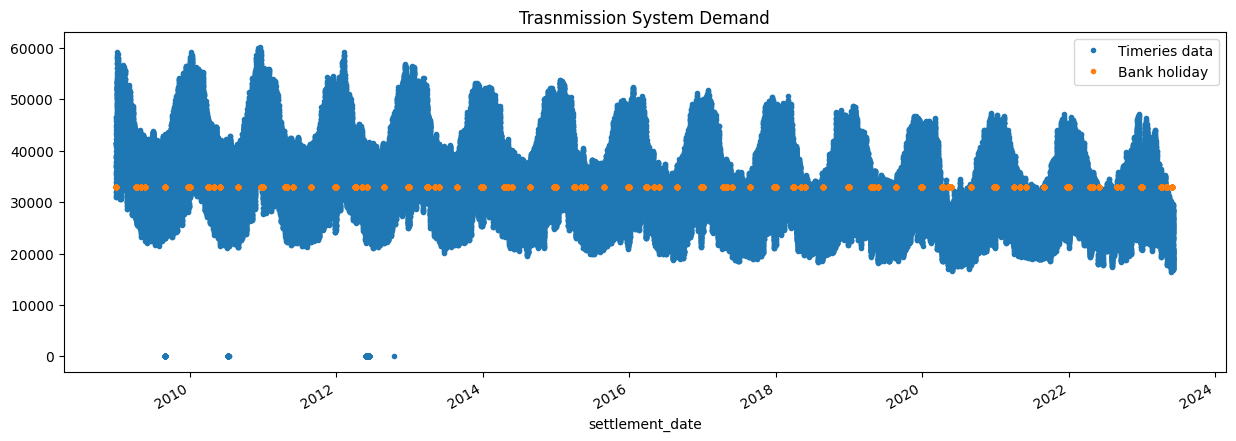

In [ ]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend()
plt.show()

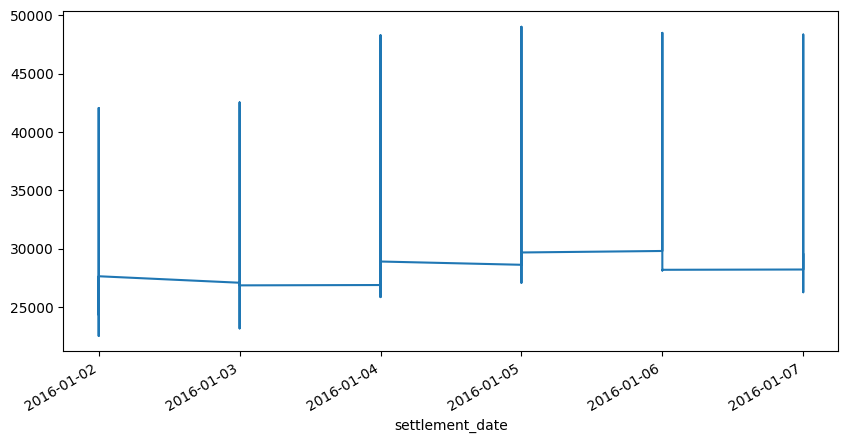

In [ ]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5))
plt.show()

In [ ]:
df_plot.head()

settlement_period     nd    tsd  england_wales_demand  \
settlement_date                                                          
2009-01-01                       1  37910  38704                 33939   
2009-01-01                       2  38047  38964                 34072   
2009-01-01                       3  37380  38651                 33615   
2009-01-01                       4  36426  37775                 32526   
2009-01-01                       5  35687  37298                 31877   

                 embedded_wind_generation  embedded_wind_capacity  \
settlement_date                                                     
2009-01-01                             54                    1403   
2009-01-01                             53                    1403   
2009-01-01                             53                    1403   
2009-01-01                             50                    1403   
2009-01-01                             50                    1403   

                 embedded_solar_generation  embedded_solar_capacity  \
settlement_date                                                       
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   

                 non_bm_stor  pump_storage_pumping  ifa_flow  ifa2_flow  \
settlement_date                                                           
2009-01-01                 0                    33      2002          0   
2009-01-01                 0                   157      2002          0   
2009-01-01                 0                   511      2002          0   
2009-01-01                 0                   589      1772          0   
2009-01-01                 0                   851      1753          0   

                 britned_flow  moyle_flow  east_west_flow  nemo_flow  \
settlement_date                                                        
2009-01-01                  0        -161               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   

                 is_holiday  
settlement_date              
2009-01-01                1  
2009-01-01                1  
2009-01-01                1  
2009-01-01                1  
2009-01-01                1

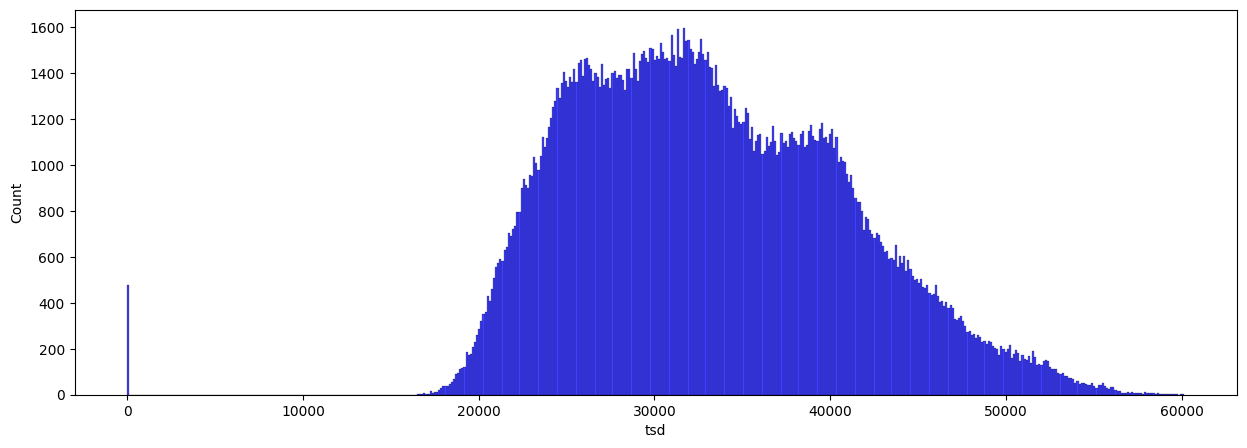

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b")
plt.show()

In [ ]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

In [ ]:
null_days

[1251504000000000000,
 1251590400000000000,
 1278633600000000000,
 1278720000000000000,
 1278979200000000000,
 1279065600000000000,
 1338249600000000000,
 1338336000000000000,
 1338422400000000000,
 1338508800000000000,
 1338595200000000000,
 1338681600000000000,
 1338768000000000000,
 1339372800000000000,
 1350172800000000000]

In [ ]:
from datetime import datetime
null_days = [datetime.fromtimestamp(ts / 1_000_000_000) for ts in null_days]
for dt in null_days:
    print(dt)


2009-08-29 00:00:00
2009-08-30 00:00:00
2010-07-09 00:00:00
2010-07-10 00:00:00
2010-07-13 00:00:00
2010-07-14 00:00:00
2012-05-29 00:00:00
2012-05-30 00:00:00
2012-05-31 00:00:00
2012-06-01 00:00:00
2012-06-02 00:00:00
2012-06-03 00:00:00
2012-06-04 00:00:00
2012-06-11 00:00:00
2012-10-14 00:00:00


In [ ]:
null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
null_days_index

[11518,
 11519,
 11520,
 11521,
 11522,
 11523,
 11524,
 11525,
 11526,
 11527,
 11528,
 11529,
 11530,
 11531,
 11532,
 11533,
 11534,
 11535,
 11536,
 11537,
 11538,
 11539,
 11540,
 11541,
 11542,
 11543,
 11544,
 11545,
 11546,
 11547,
 11548,
 11549,
 11550,
 11551,
 11552,
 11553,
 11554,
 11555,
 11556,
 11557,
 11558,
 11559,
 11560,
 11561,
 11562,
 11563,
 11564,
 11565,
 11566,
 11567,
 11568,
 11569,
 11570,
 11571,
 11572,
 11573,
 11574,
 11575,
 11576,
 11577,
 11578,
 11579,
 11580,
 11581,
 11582,
 11583,
 11584,
 11585,
 11586,
 11587,
 11588,
 11589,
 11590,
 11591,
 11592,
 11593,
 11594,
 11595,
 11596,
 11597,
 11598,
 11599,
 11600,
 11601,
 11602,
 11603,
 11604,
 11605,
 11606,
 11607,
 11608,
 11609,
 11610,
 11611,
 11612,
 11613,
 26588,
 26589,
 26590,
 26591,
 26592,
 26593,
 26594,
 26595,
 26596,
 26597,
 26598,
 26599,
 26600,
 26601,
 26602,
 26603,
 26604,
 26605,
 26606,
 26607,
 26608,
 26609,
 26610,
 26611,
 26612,
 26613,
 26614,
 26615,
 26616,


In [ ]:
from datetime import timedelta

In [ ]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"


In [ ]:
# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

settlement_date  settlement_period period_hour     nd    tsd  \
102069      2014-11-12                 34    16:30:00  46035  47365   
1004        2009-01-21                 45    22:00:00  41257  42540   
119335      2015-11-07                 22    10:30:00  35056  35454   
170634      2018-10-11                 15     7:00:00  31716  32226   
112227      2015-06-12                 18     8:30:00  34258  34887   
195745      2020-03-17                 24    11:30:00  33031  33687   
94449       2014-06-06                 46    22:30:00  29125  30071   

        england_wales_demand  embedded_wind_generation  \
102069                 42116                      1503   
1004                   37059                      1141   
119335                 31220                      1940   
170634                 29256                      2297   
112227                 30797                       523   
195745                 30532                      3322   
94449                  26434                      1021   

        embedded_wind_capacity  embedded_solar_generation  \
102069                    3939                          0   
1004                      1403                          0   
119335                    4013                        399   
170634                    5911                          1   
112227                    3889                       2220   
195745                    6465                       3750   
94449                     3665                          0   

        embedded_solar_capacity  non_bm_stor  pump_storage_pumping  ifa_flow  \
102069                     5685            0                    15      1838   
1004                          0            0                    86      -298   
119335                     8982          218                    16      1497   
170634                    13052            0                    10      1459   
112227                     8663          217                    14      1997   
195745                    13080            0                    11      2005   
94449                      4810            0                    15      1494   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
102069          0          1005        -251            -464          0   
1004            0             0        -299               0          0   
119335          0          1011          17               6          0   
170634          0           990          71             313          0   
112227          0           979         -58            -274          0   
195745          0          1058         -45             139       1000   
94449           0          1003        -201            -230          0   

        is_holiday  
102069           0  
1004             0  
119335           0  
170634           0  
112227           0  
195745           0  
94449            0

In [ ]:
# Convert the period_hour column to timedelta
df['period_hour'] = pd.to_timedelta(df['period_hour'])

In [ ]:
# Combine the settlement_date and period_hour to create a new datetime column
df['settlement_date'] =pd.to_datetime(df['settlement_date'] + df['period_hour'])

In [ ]:
df.sample(5)

settlement_date  settlement_period     period_hour     nd    tsd  \
86955  2014-01-01 18:30:00                 38 0 days 18:30:00  38536  39847   
248855 2023-03-29 02:30:00                  6 0 days 02:30:00  22735  24516   
82689  2013-10-04 21:30:00                 44 0 days 21:30:00  33881  35131   
227174 2022-01-01 08:00:00                 17 0 days 08:00:00  18638  23620   
71271  2013-02-08 23:30:00                 48 0 days 23:30:00  33952  35823   

        england_wales_demand  embedded_wind_generation  \
86955                  35083                      1476   
248855                 20778                      1252   
82689                  30859                       399   
227174                 17909                      3658   
71271                  30430                        43   

        embedded_wind_capacity  embedded_solar_generation  \
86955                     2434                          0   
248855                    6545                          0   
82689                     2337                          0   
227174                    6527                          0   
71271                     2085                          0   

        embedded_solar_capacity  non_bm_stor  pump_storage_pumping  ifa_flow  \
86955                      3349            0                    15      1991   
248855                    13080            0                  1242       455   
82689                      3020            0                     6      1923   
227174                    13670            0                   582     -1022   
71271                      2213            0                   861       996   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
86955           0          1000        -216            -480          0   
248855        653          1050          -6             -33        722   
82689           0           983        -251            -493          0   
227174         -4         -1015         141              44      -1021   
71271           0           994        -160            -250          0   

        is_holiday  
86955            1  
248855           0  
82689            0  
227174           0  
71271            0

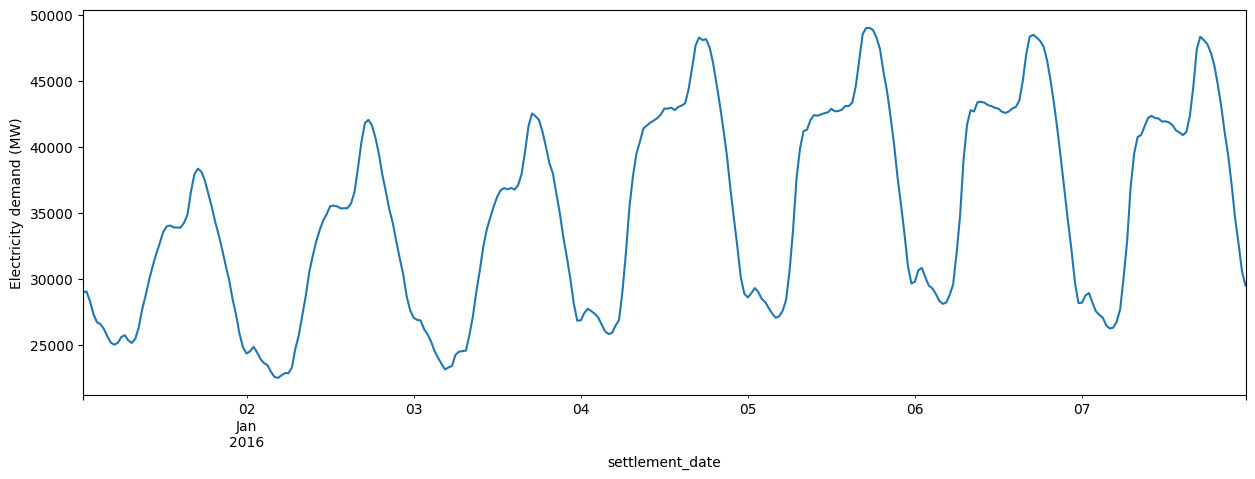

In [ ]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df

In [ ]:
def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [ ]:
df.index

DatetimeIndex(['2009-01-01 00:00:00', '2009-01-01 00:30:00',
               '2009-01-01 01:00:00', '2009-01-01 01:30:00',
               '2009-01-01 02:00:00', '2009-01-01 02:30:00',
               '2009-01-01 03:00:00', '2009-01-01 03:30:00',
               '2009-01-01 04:00:00', '2009-01-01 04:30:00',
               ...
               '2023-06-06 19:00:00', '2023-06-06 19:30:00',
               '2023-06-06 20:00:00', '2023-06-06 20:30:00',
               '2023-06-06 21:00:00', '2023-06-06 21:30:00',
               '2023-06-06 22:00:00', '2023-06-06 22:30:00',
               '2023-06-06 23:00:00', '2023-06-06 23:30:00'],
              dtype='datetime64[ns]', name='settlement_date', length=252210, freq=None)

In [ ]:
# Set the "settlement_date" column as the index
# df.set_index('settlement_date', inplace=True)

KeyError: ignored

In [ ]:
df

settlement_period     period_hour     nd    tsd  \
settlement_date                                                        
2009-01-01 00:00:00                  1 0 days 00:00:00  37910  38704   
2009-01-01 00:30:00                  2 0 days 00:30:00  38047  38964   
2009-01-01 01:00:00                  3 0 days 01:00:00  37380  38651   
2009-01-01 01:30:00                  4 0 days 01:30:00  36426  37775   
2009-01-01 02:00:00                  5 0 days 02:00:00  35687  37298   
...                                ...             ...    ...    ...   
2023-06-06 21:30:00                 44 0 days 21:30:00  26340  27858   
2023-06-06 22:00:00                 45 0 days 22:00:00  25092  26896   
2023-06-06 22:30:00                 46 0 days 22:30:00  24060  25928   
2023-06-06 23:00:00                 47 0 days 23:00:00  22590  24258   
2023-06-06 23:30:00                 48 0 days 23:30:00  21355  23166   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2009-01-01 00:00:00                 33939                        54   
2009-01-01 00:30:00                 34072                        53   
2009-01-01 01:00:00                 33615                        53   
2009-01-01 01:30:00                 32526                        50   
2009-01-01 02:00:00                 31877                        50   
...                                   ...                       ...   
2023-06-06 21:30:00                 24082                      1068   
2023-06-06 22:00:00                 22909                      1065   
2023-06-06 22:30:00                 21921                      1062   
2023-06-06 23:00:00                 20574                      1046   
2023-06-06 23:30:00                 19439                      1029   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2009-01-01 00:00:00                    1403                          0   
2009-01-01 00:30:00                    1403                          0   
2009-01-01 01:00:00                    1403                          0   
2009-01-01 01:30:00                    1403                          0   
2009-01-01 02:00:00                    1403                          0   
...                                     ...                        ...   
2023-06-06 21:30:00                    6538                          0   
2023-06-06 22:00:00                    6538                          0   
2023-06-06 22:30:00                    6538                          0   
2023-06-06 23:00:00                    6538                          0   
2023-06-06 23:30:00                    6538                          0   

                     embedded_solar_capacity  non_bm_stor  \
settlement_date                                             
2009-01-01 00:00:00                        0            0   
2009-01-01 00:30:00                        0            0   
2009-01-01 01:00:00                        0            0   
2009-01-01 01:30:00                        0            0   
2009-01-01 02:00:00                        0            0   
...                                      ...          ...   
2023-06-06 21:30:00                    13081            0   
2023-06-06 22:00:00                    13081            0   
2023-06-06 22:30:00                    13081            0   
2023-06-06 23:00:00                    13081            0   
2023-06-06 23:30:00                    13081            0   

                     pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  \
settlement_date                                                                
2009-01-01 00:00:00                    33      2002          0             0   
2009-01-01 00:30:00                   157      2002          0             0   
2009-01-01 01:00:00                   511      2002          0             0   
200

In [ ]:
df = create_features(df)
df = add_lags(df)

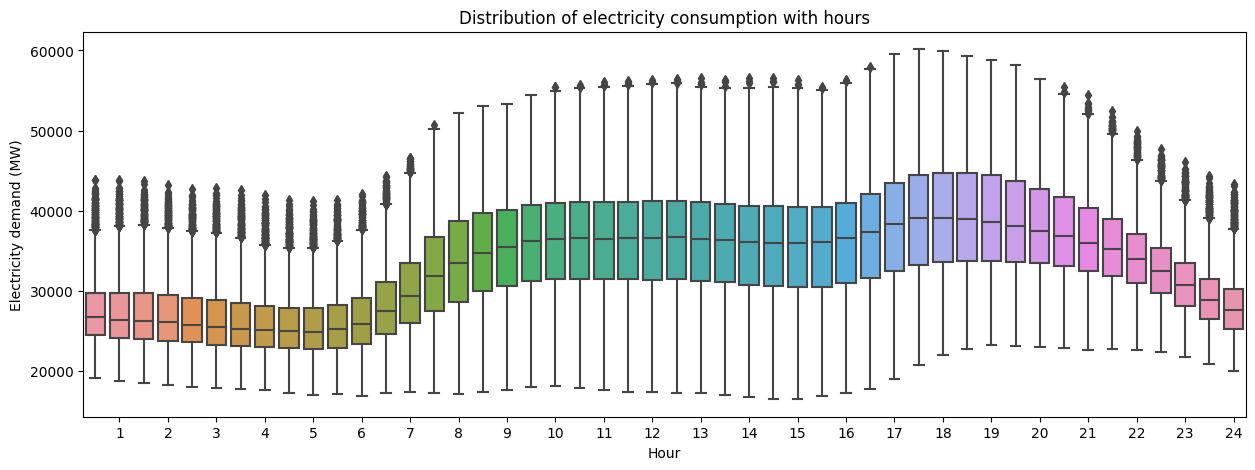

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours")
plt.show()

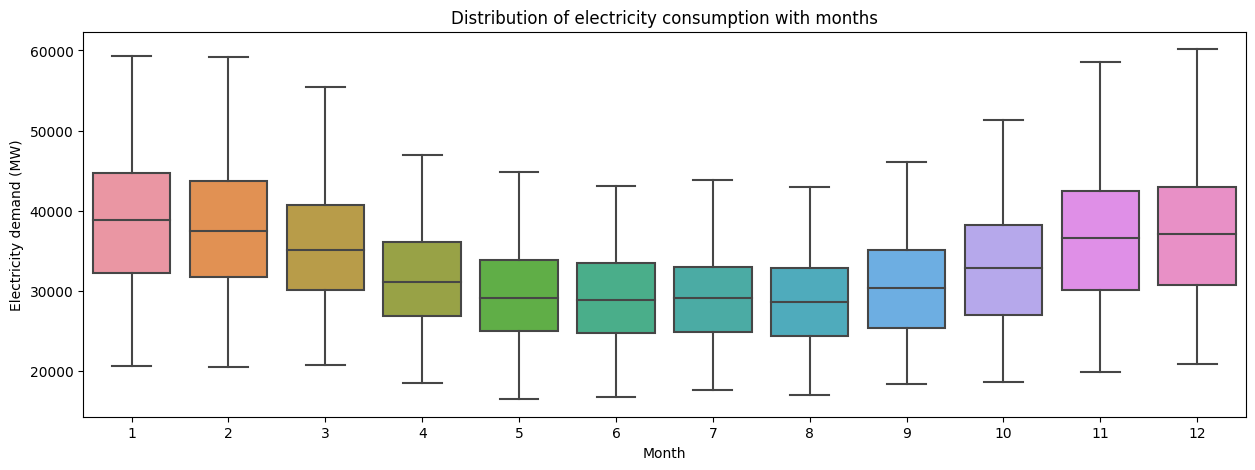

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months")
plt.show()

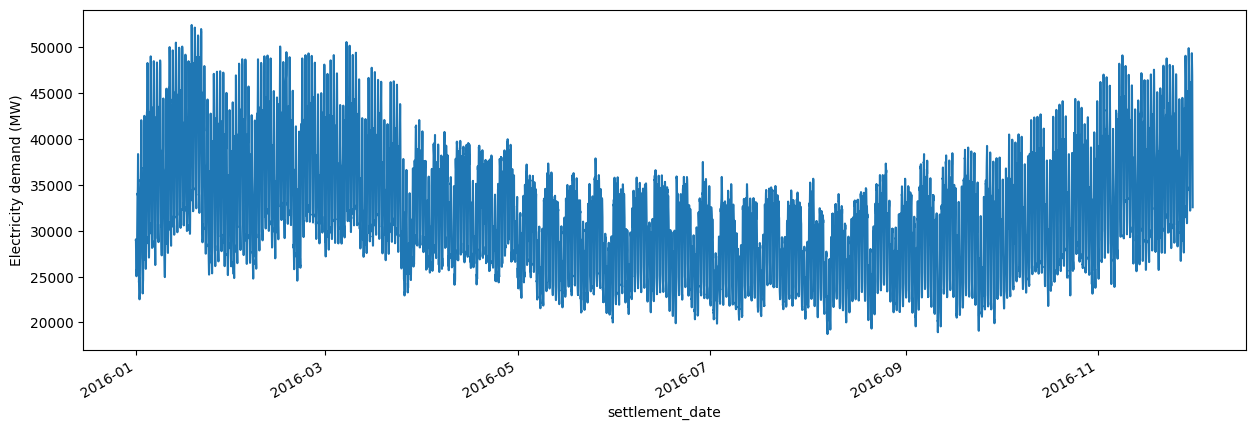

In [ ]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
)
plt.show()

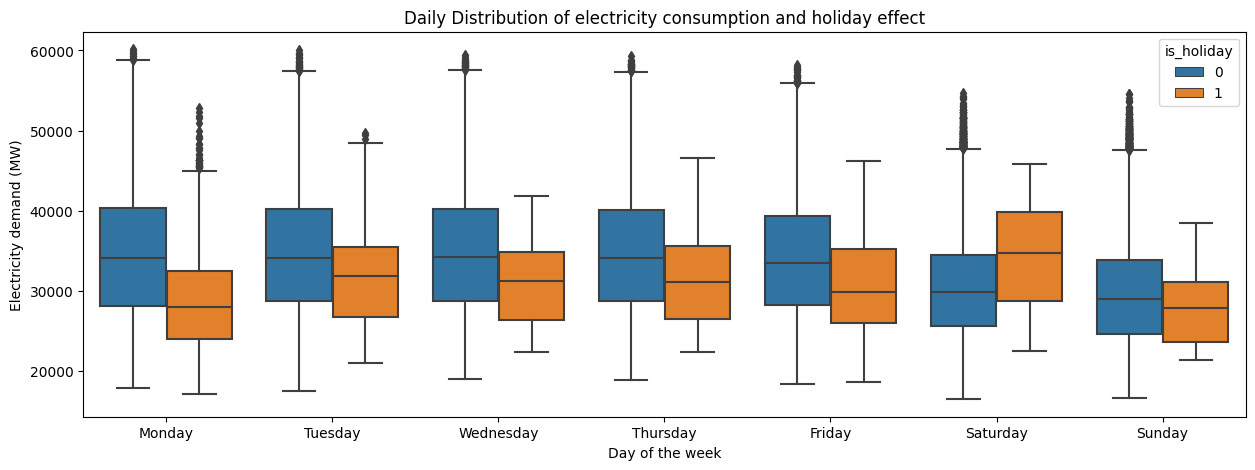

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect")
plt.show()

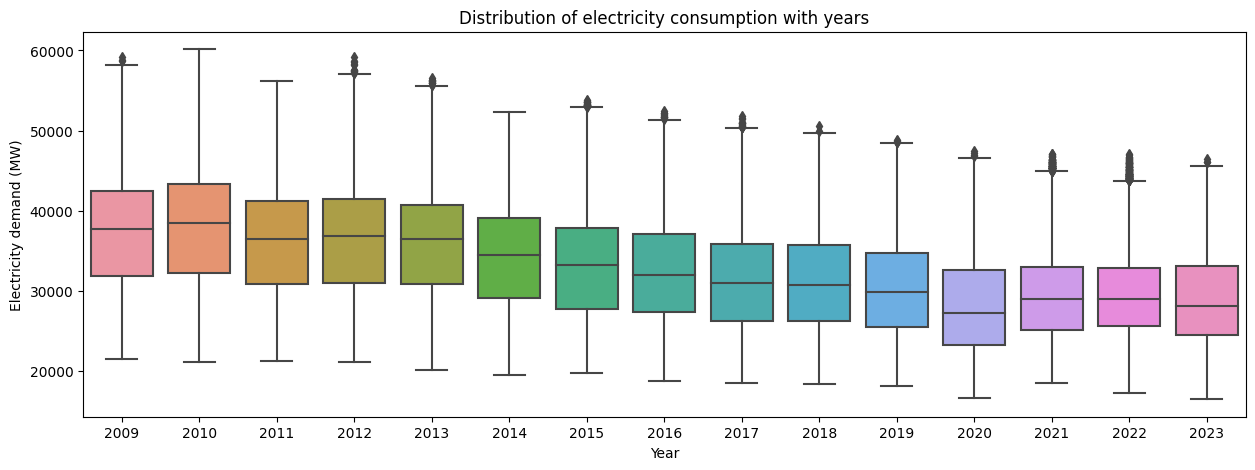

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years")
plt.show()

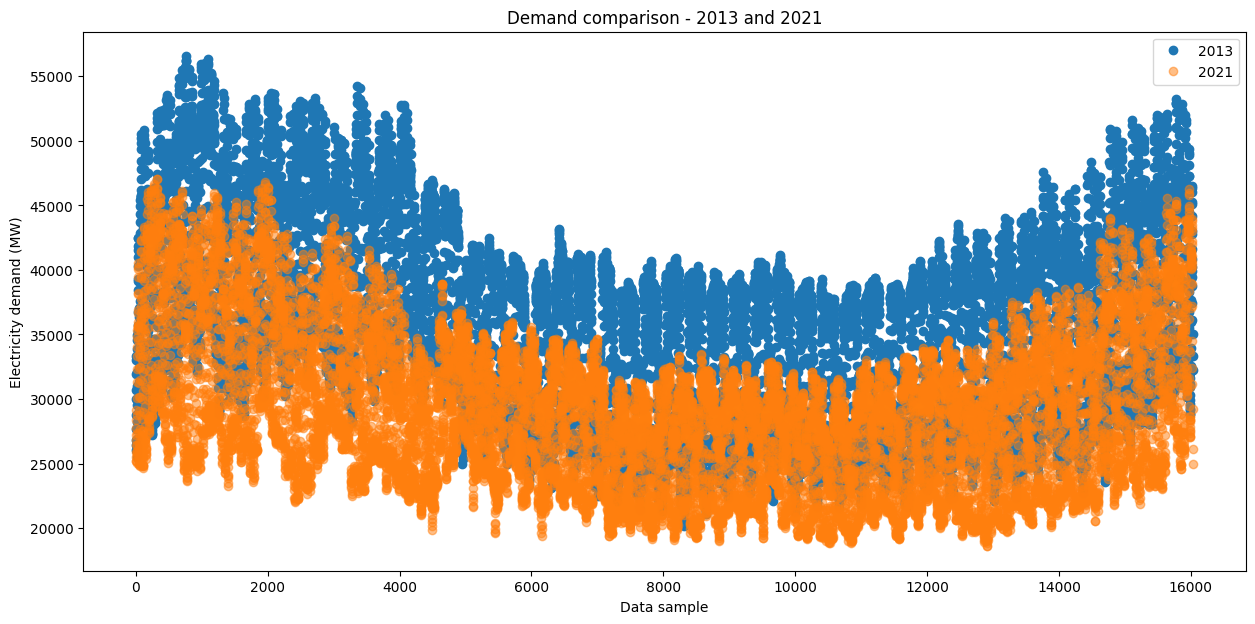

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021")
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

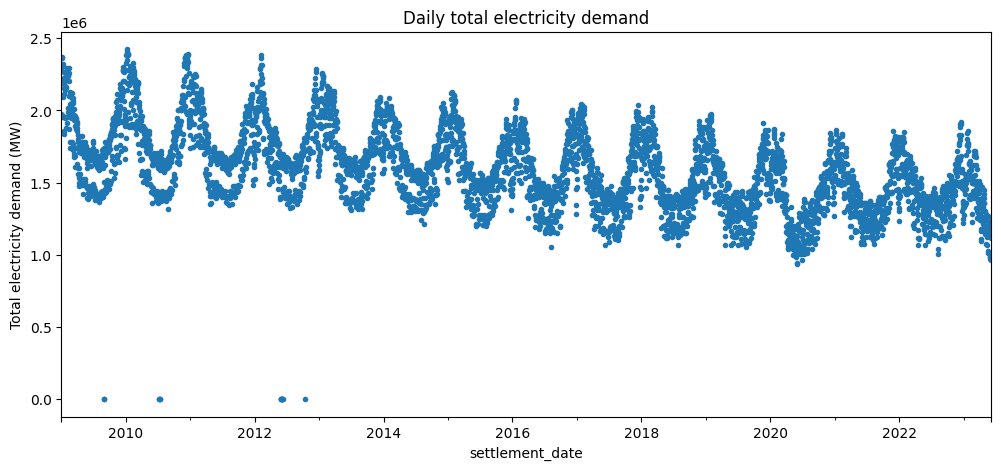

In [ ]:
df_sarima = df["tsd"].resample("D").sum().to_frame()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year

df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

In [ ]:
null_days

[datetime.datetime(2009, 8, 29, 0, 0),
 datetime.datetime(2009, 8, 30, 0, 0),
 datetime.datetime(2010, 7, 9, 0, 0),
 datetime.datetime(2010, 7, 10, 0, 0),
 datetime.datetime(2010, 7, 13, 0, 0),
 datetime.datetime(2010, 7, 14, 0, 0),
 datetime.datetime(2012, 5, 29, 0, 0),
 datetime.datetime(2012, 5, 30, 0, 0),
 datetime.datetime(2012, 5, 31, 0, 0),
 datetime.datetime(2012, 6, 1, 0, 0),
 datetime.datetime(2012, 6, 2, 0, 0),
 datetime.datetime(2012, 6, 3, 0, 0),
 datetime.datetime(2012, 6, 4, 0, 0),
 datetime.datetime(2012, 6, 11, 0, 0),
 datetime.datetime(2012, 10, 14, 0, 0)]

In [ ]:
df_sarima

tsd  month  year
settlement_date                      
2009-01-01       1849363      1  2009
2009-01-02       1974406      1  2009
2009-01-03       1952054      1  2009
2009-01-04       1968670      1  2009
2009-01-05       2271471      1  2009
...                  ...    ...   ...
2023-06-02       1113477      6  2023
2023-06-03        968096      6  2023
2023-06-04        963342      6  2023
2023-06-05       1151595      6  2023
2023-06-06       1222624      6  2023

[5270 rows x 3 columns]

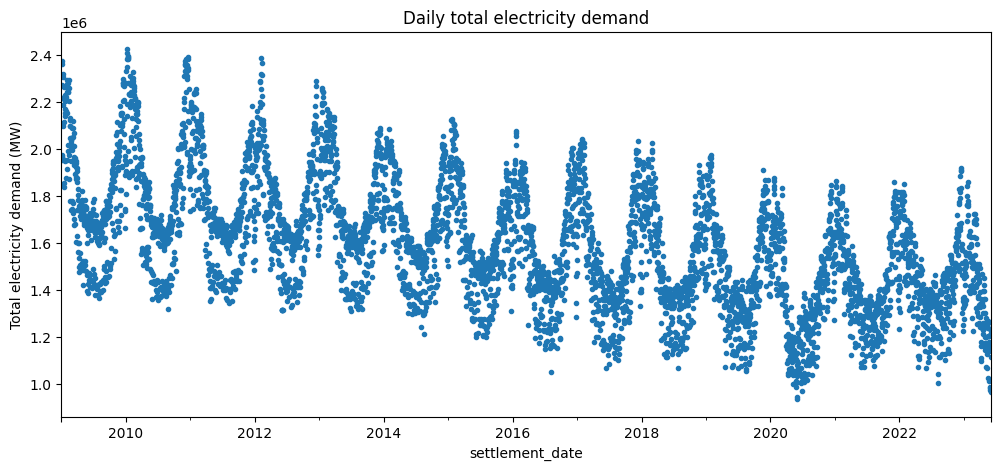

In [ ]:
null_info = zip(
    df_sarima.loc[null_days].index.month, df_sarima.loc[null_days].index.year
)

mean_values = [
    df_sarima.loc[
        (df_sarima["month"] == info[0]) & (df_sarima["year"] == info[1]), "tsd"
    ].mean()
    for info in null_info
]

df_sarima.loc[null_days, "tsd"] = mean_values

df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

In [ ]:
df_sarima["lag_day"] = df_sarima["tsd"].shift(1)
df_sarima["lag_year"] = df_sarima["tsd"].shift(364)


df_sarima["difference_day"] = df_sarima["tsd"] - df_sarima["lag_day"]
df_sarima["difference_year"] = df_sarima["tsd"] - df_sarima["lag_year"]

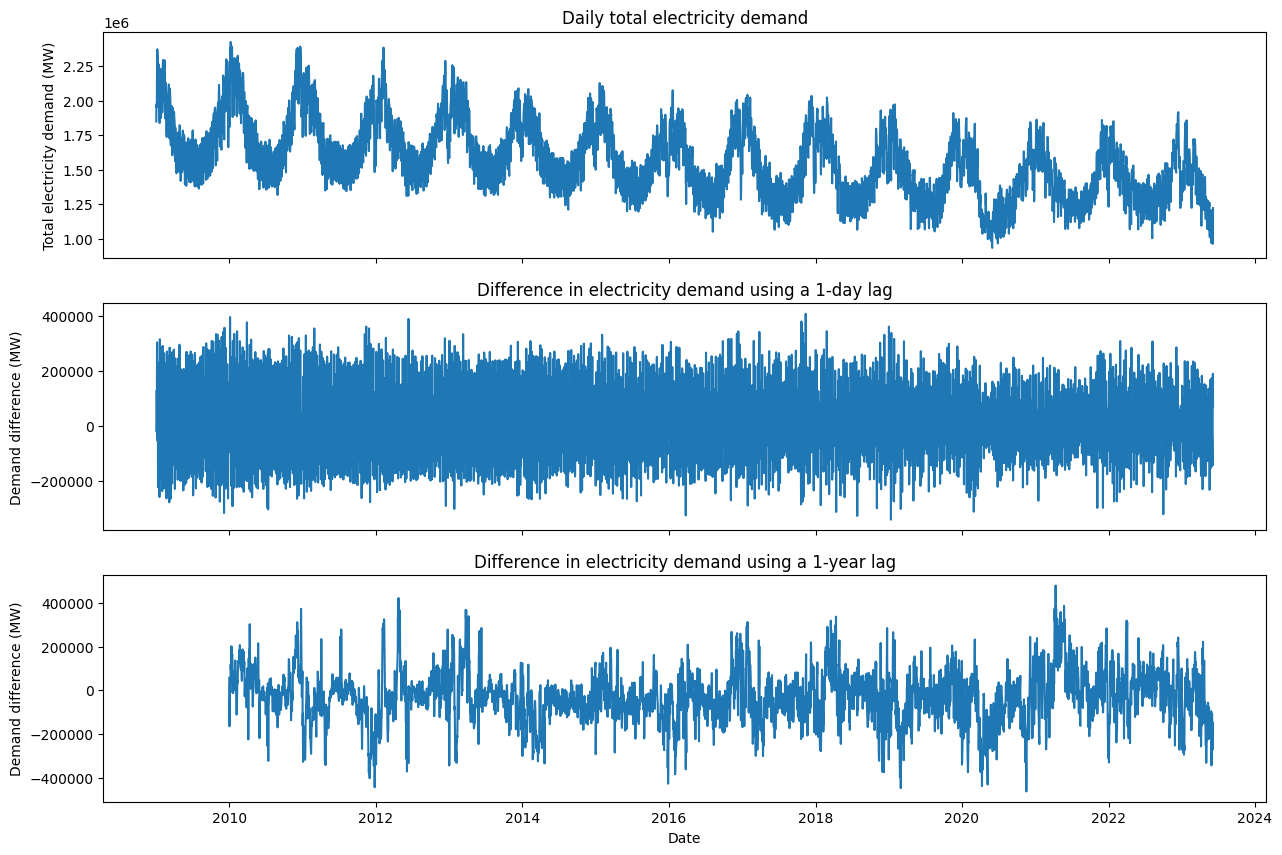

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes.ravel()
axes[0].plot(df_sarima.index, df_sarima["tsd"])
axes[0].set_ylabel("Total electricity demand (MW)")
axes[0].set_title("Daily total electricity demand")
axes[1].plot(df_sarima.index, df_sarima["difference_day"])
axes[1].set_ylabel("Demand difference (MW)")
axes[1].set_title("Difference in electricity demand using a 1-day lag")
axes[2].plot(df_sarima.index, df_sarima["difference_year"])
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Demand difference (MW)")
axes[2].set_title("Difference in electricity demand using a 1-year lag")
plt.show()

In [ ]:
def dftest(timeseries, window_size):
    """
    Perform ADFuller test, report the results and plot rolling statistics

    Args:
        - timeseries: time series data
        - window_size: window size for rolling statistics
    """
    dftest = sm.stattools.adfuller(
        timeseries,
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid(True)
    plt.show(block=False)


def autocorr_plots(data, lags=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot

    Args:
        - data: time series data
        - lags: number of lags for the autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags, ax=acf, zero=True)
    sm.graphics.plot_pacf(data, lags=lags, ax=pacf, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()

In [ ]:
def autocorr_plots_dual_lags(data, lags_1=None, lags_2=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot
    using two lags

    Args:
        - data: time series data
        - lags_1: number of lags for first set of autocorrelation plots
            Default value is None
        - lags_2: number of lags for first set of autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 14))
    layout = (5, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf_1 = plt.subplot2grid(layout, (1, 0))
    pacf_1 = plt.subplot2grid(layout, (2, 0))
    acf_2 = plt.subplot2grid(layout, (3, 0))
    pacf_2 = plt.subplot2grid(layout, (4, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags_1, ax=acf_1, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_1, ax=pacf_1, zero=True, method="ywm")
    sm.graphics.plot_acf(data, lags=lags_2, ax=acf_2, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_2, ax=pacf_2, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()

Test Statistic            -3.593661
p-value                    0.005883
Lags Used                 33.000000
Observations Used       5236.000000
Critical Value (1%)       -3.431600
Critical Value (5%)       -2.862092
Critical Value (10%)      -2.567064
dtype: float64


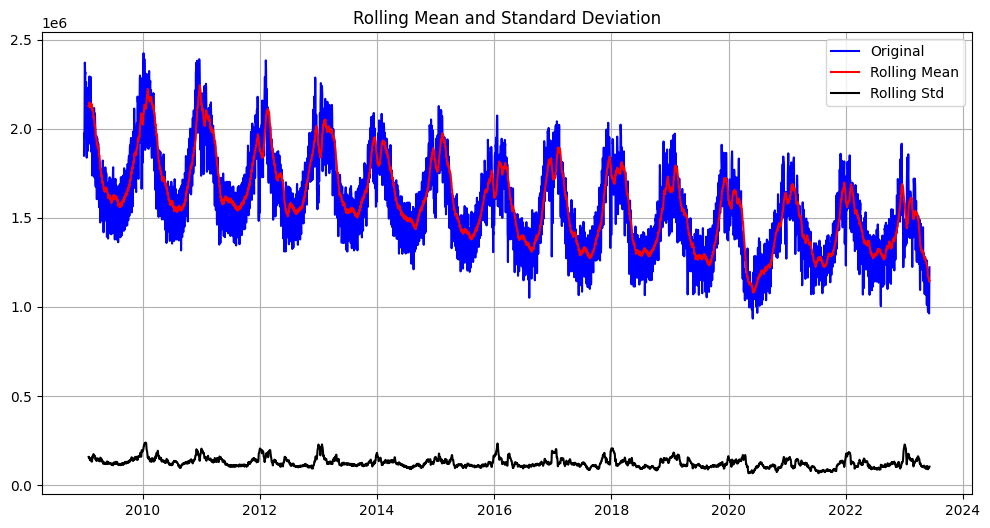

In [ ]:
dftest(df_sarima["tsd"], 30)

Test Statistic         -1.699762e+01
p-value                 8.776061e-30
Lags Used               3.300000e+01
Observations Used       5.235000e+03
Critical Value (1%)    -3.431600e+00
Critical Value (5%)    -2.862092e+00
Critical Value (10%)   -2.567064e+00
dtype: float64


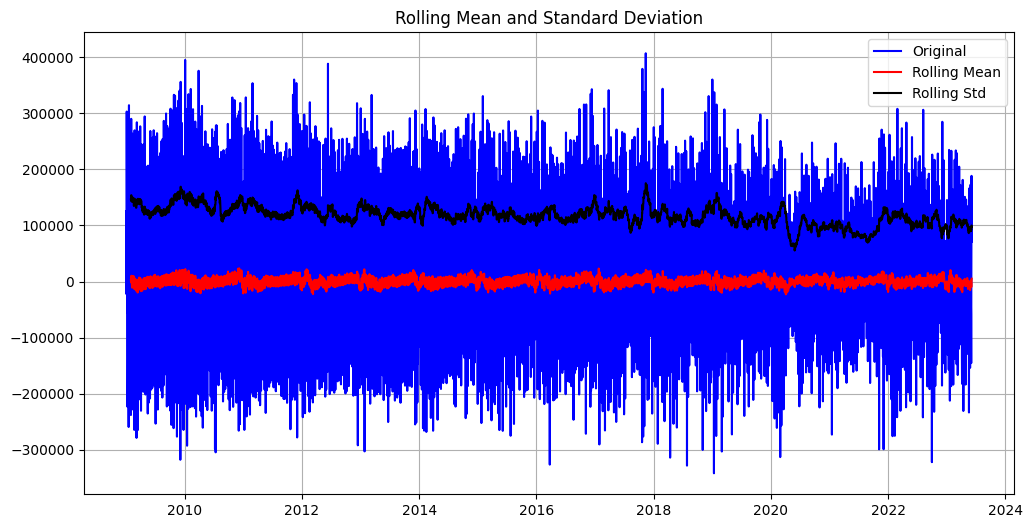

In [ ]:
dftest(df_sarima["difference_day"].dropna(), 30)

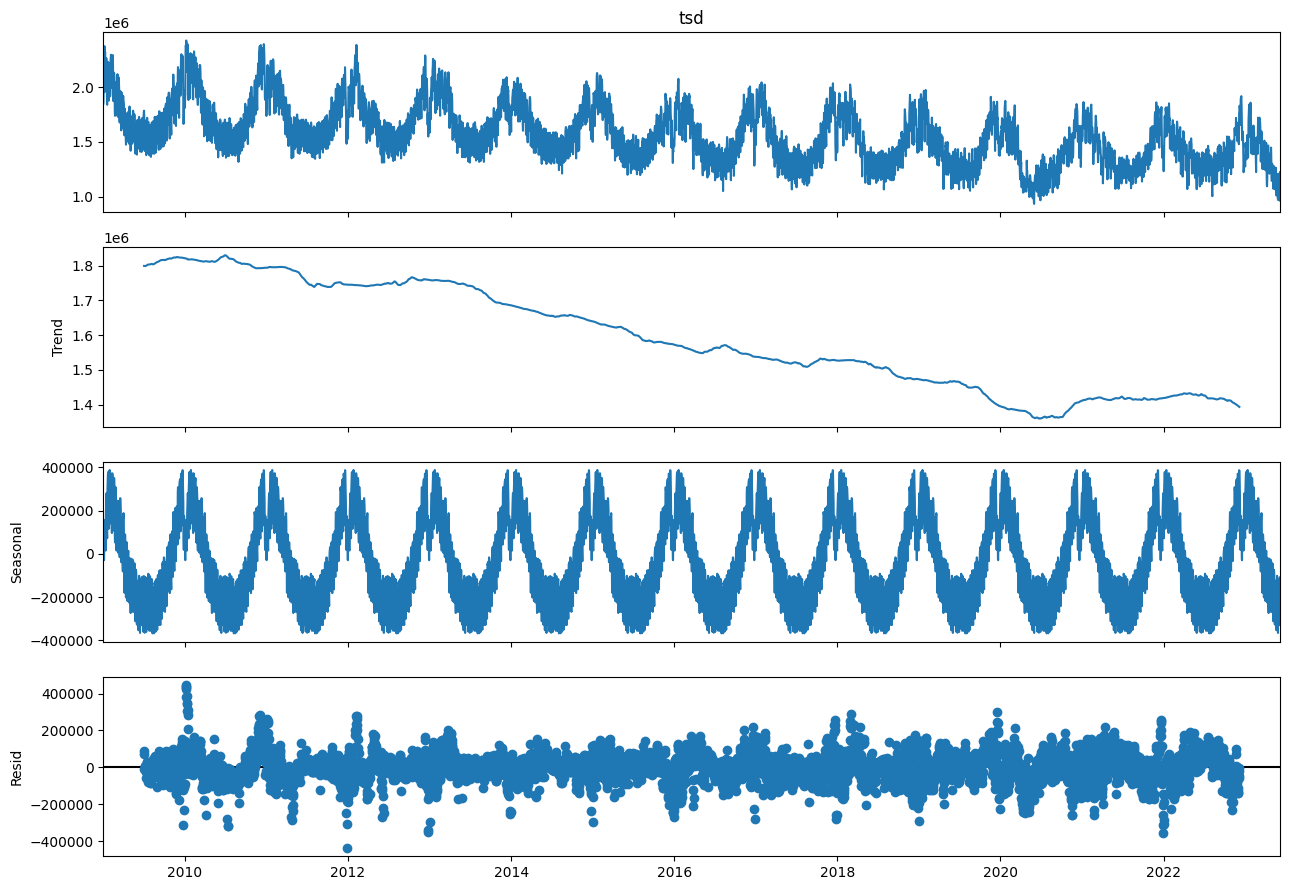

In [ ]:
decompose = sm.seasonal_decompose(df_sarima["tsd"].dropna(), period=364)

fig = decompose.plot()
fig.set_size_inches((13, 9))
fig.tight_layout()

In [ ]:
dftest(decompose.seasonal, 364)

Test Statistic            -5.012840
p-value                    0.000021
Lags Used                 33.000000
Observations Used       5236.000000
Critical Value (1%)       -3.431600
Critical Value (5%)       -2.862092
Critical Value (10%)      -2.567064
dtype: float64


Test Statistic         -8.682370e+00
p-value                 4.251936e-14
Lags Used               2.100000e+01
Observations Used       4.884000e+03
Critical Value (1%)    -3.431690e+00
Critical Value (5%)    -2.862132e+00
Critical Value (10%)   -2.567085e+00
dtype: float64


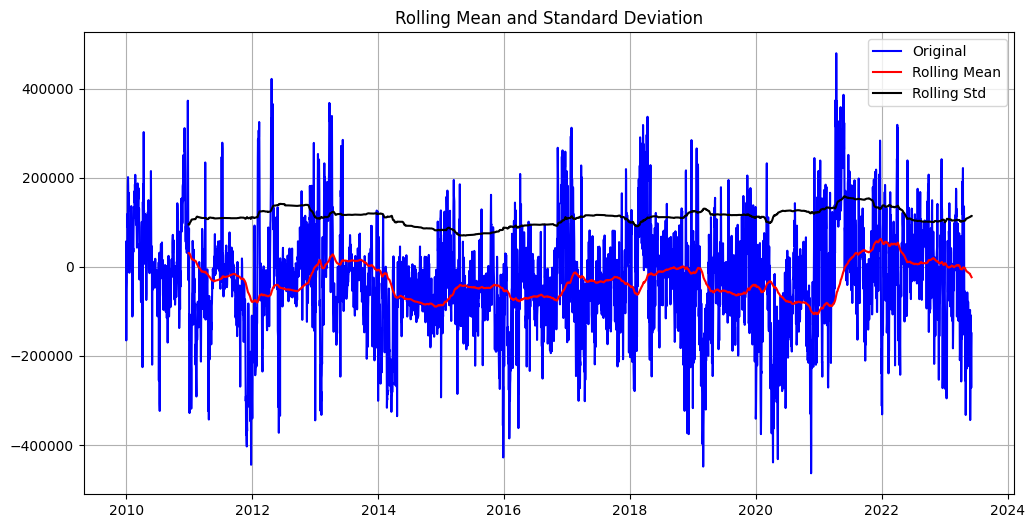

In [ ]:
dftest(df_sarima["difference_year"].dropna(), 364)

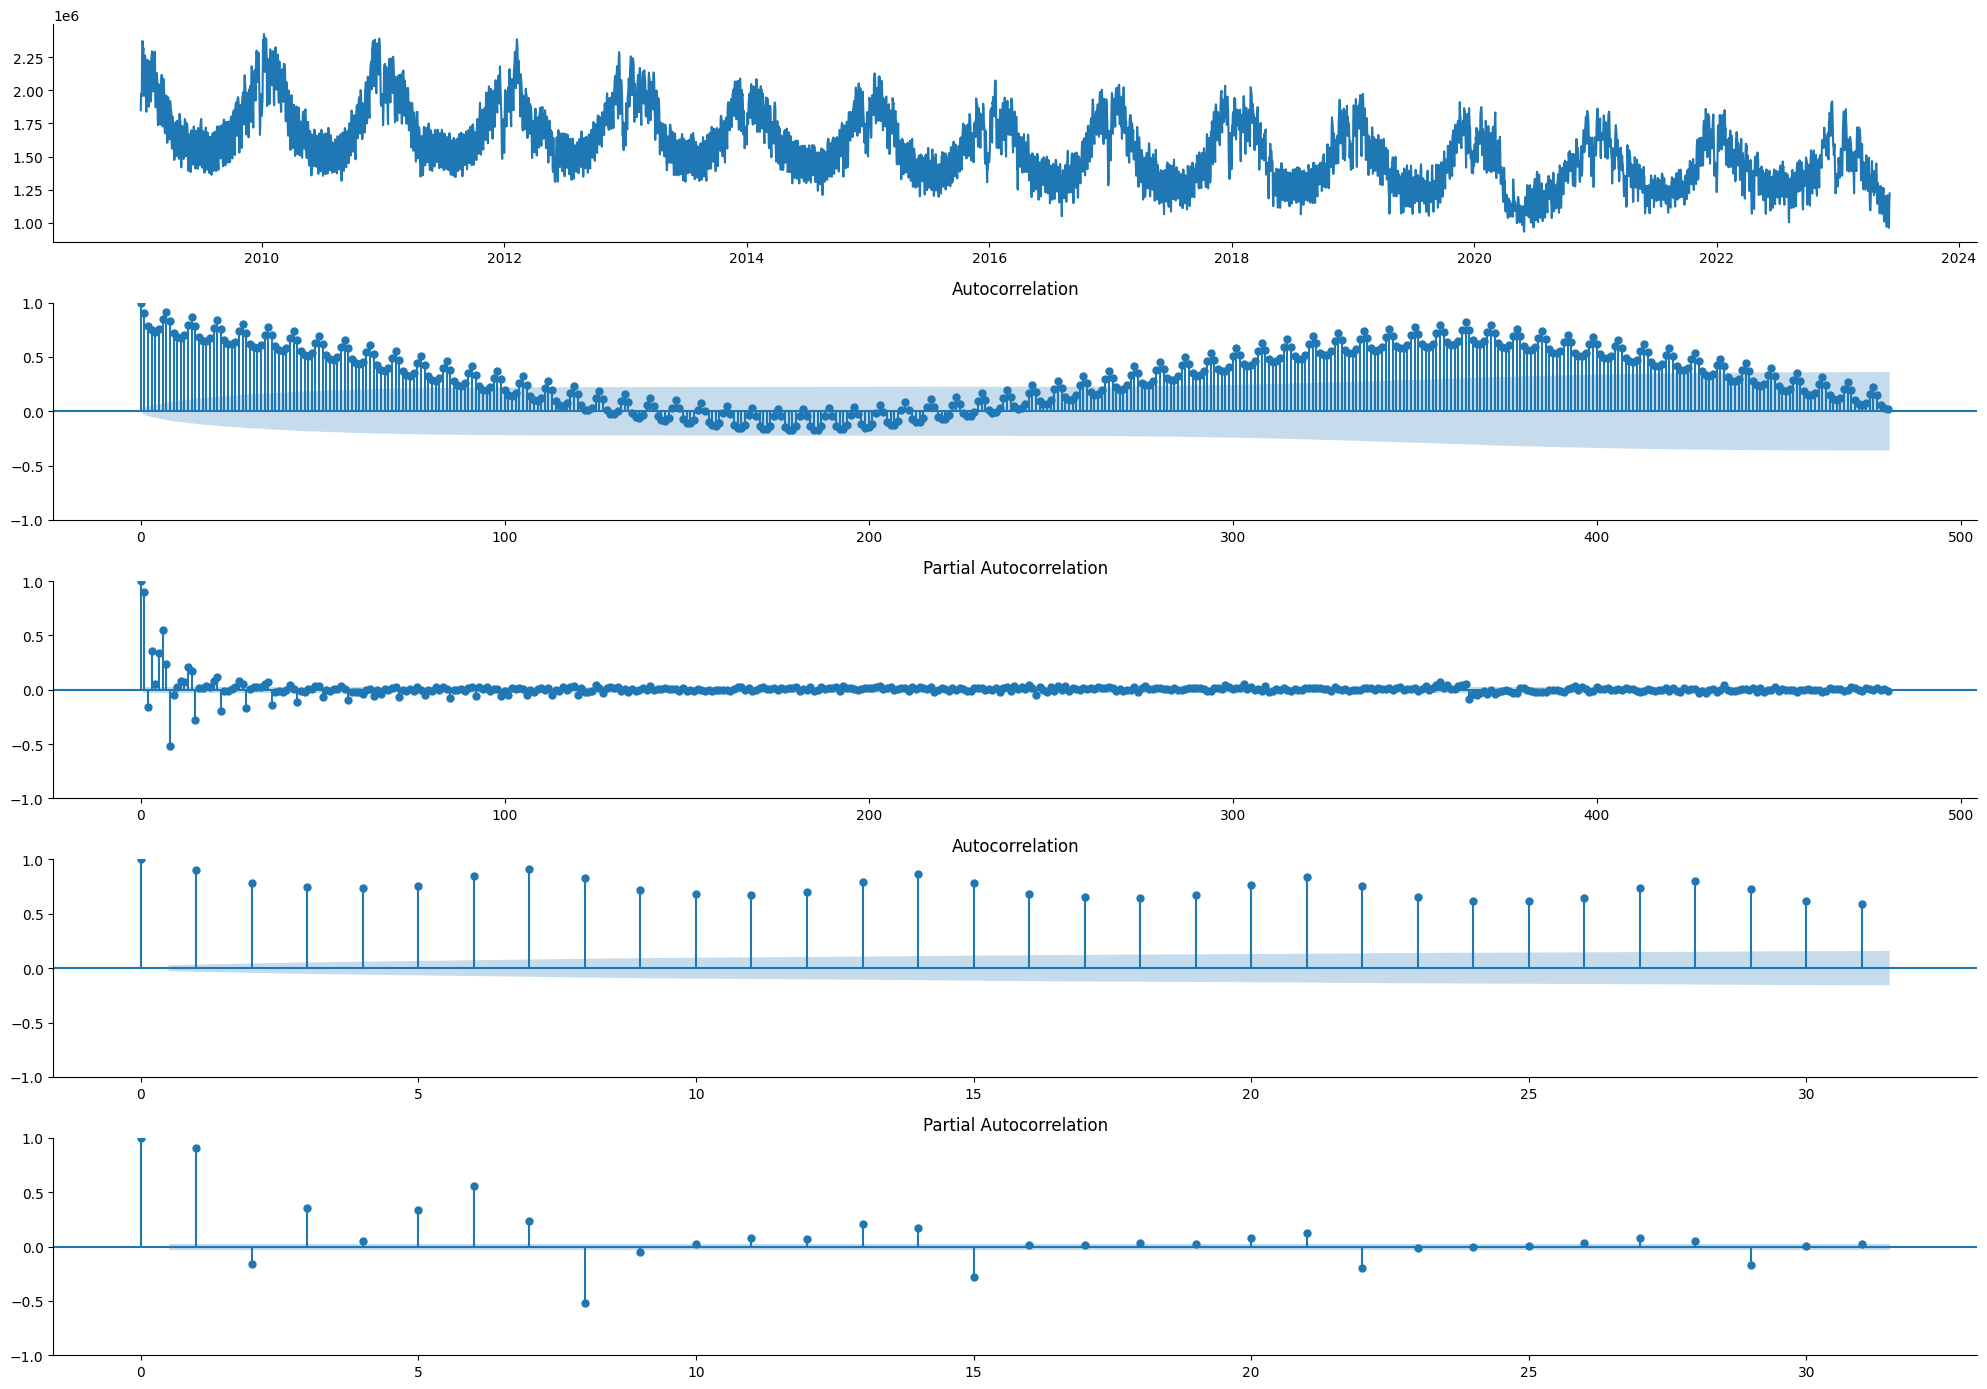

In [ ]:
autocorr_plots_dual_lags(df_sarima["tsd"], lags_1=480, lags_2=31)

In [ ]:
autocorr_plots_dual_lags(decompose.seasonal, lags_1=480, lags_2=31)

In [ ]:
threshold_date = "01-01-2021"
train_data = df_sarima.loc[df_sarima.index < threshold_date, "tsd"]
test_data = df_sarima.loc[df_sarima.index >= threshold_date, "tsd"]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label="Training set")
test_data.plot(ax=ax, label="Test set")
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend()
plt.show()

In [ ]:

def stats_test(sar_model):
    """
    Perform statistical tests on SARIMA model and print the results

    Args:
        - sar_model: SARIMA model
    """

    # create and run statistical tests on model
    norm_val, norm_p, skew, kurtosis = sar_model.test_normality("jarquebera")[0]
    lb_val, lb_p = sar_model.test_serial_correlation(
        method="ljungbox",
    )[0]
    het_val, het_p = sar_model.test_heteroskedasticity("breakvar")[0]

    # we want to look at largest lag for Ljung-Box, so take largest number in series
    # there's intelligence in the method to determine how many lags back to calculate this stat
    lb_val = lb_val[-1]
    lb_p = lb_p[-1]
    durbin_watson = statsmodels.stats.stattools.durbin_watson(
        sar_model.filter_results.standardized_forecasts_error[
            0, sar_model.loglikelihood_burn :
        ]
    )

    print("Normality: val={:.3f}, p={:.3f}".format(norm_val, norm_p))
    print("Ljung-Box: val={:.3f}, p={:.3f}".format(lb_val, lb_p))
    print("Heteroskedasticity: val={:.3f}, p={:.3f}".format(het_val, het_p))
    print("Durbin-Watson: d={:.2f}".format(durbin_watson))

In [ ]:
def create_predict_analyse(
    timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag
):
    """
    Create SARIMA model and perform the following actions:
        - Perform statisticals tests to check if the model parameters are right
        - Plot model diagnostics
        - Predict on test data
        - Compute MAPE
        - Plot test data, prediction and confidence interval

    Args:
        - timeseries: time series data
        - order: SARIMA order parameters
        - seasonal_order: SARIMA seasonal order parameters
        - max_iter: maximum number of iterations to compute SARIMA values
        - lags: number of lags used for model diagnostics
        - test_data: test data
        - disp_flag: boolean variable to display SARIMA model iterations

    Returns:
        - execution_time: SARIMA model runtime
        - mape: MAPE on test data
        - sarima_model: SARIMA model created using the function arguments
    """

    # Create and fit SARIMA model
    start_time = datetime.now()
    sarima_model = sm.statespace.SARIMAX(
        timeseries, order=order, seasonal_order=seasonal_order
    ).fit(maxiter=max_iter, disp=disp_flag)
    execution_time = datetime.now() - start_time

    # Perform statistical tests on model
    stats_test(sarima_model)
    print("-------------------------------------------------------------")

    # Plot SARIMA model diagnostics
    sarima_model.plot_diagnostics(
        lags=lags,
        figsize=(20, 12),
    )

    # Predict on test data
    predict = sarima_model.get_prediction(
        start="01-01-2021", end=str(test_data.index[-1].date())
    )
    confidence_int = predict.conf_int(alpha=0.05)
    prediction = predict.predicted_mean

    # Calculate MAPE on test data
    mape = mean_absolute_percentage_error(test_data.values, prediction.values)

    # Plot test data, predictions and confidence interval
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(prediction, label="Prediction")
    ax.plot(test_data, label="Test data")
    ax.fill_between(
        confidence_int.index,
        confidence_int["lower tsd"],
        confidence_int["upper tsd"],
        alpha=0.3,
    )
    ax.set_title("Prediction on test data")
    ax.set_ylabel("Total power consumption (MW)")
    ax.legend()

    return execution_time, mape, sarima_model

Normality: val=1086.819, p=0.000
Ljung-Box: val=7216.633, p=0.000
Heteroskedasticity: val=0.865, p=0.006
Durbin-Watson: d=2.03
-------------------------------------------------------------


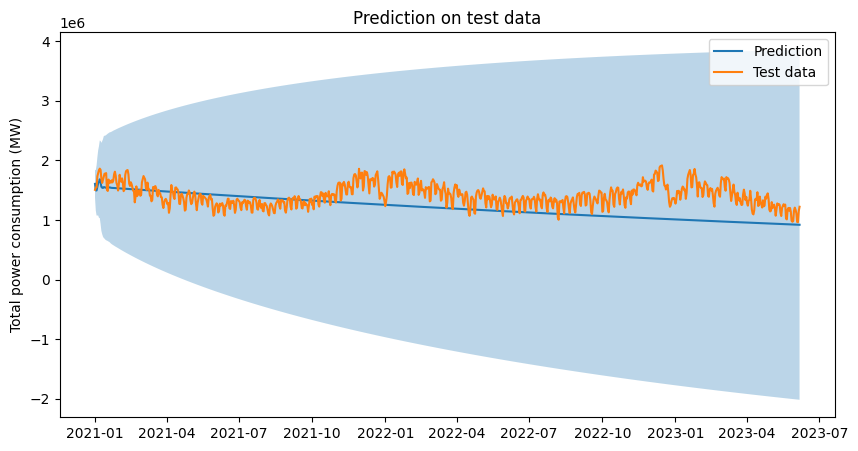

In [ ]:
[execution_time_0, mape_0, sarima_model_0] = create_predict_analyse(
    train_data, (1, 0, 1), (1, 0, 1, 12), 75, 31, test_data, False
)

In [ ]:
print(f"Model 0 MAPE value: {mape_0}")
print(f"Model 0 runtime: {execution_time_0}")

Model 0 MAPE value: 17.7739138508102
Model 0 runtime: 0:00:16.230240


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Normality: val=1754.679, p=0.000
Ljung-Box: val=513.530, p=0.000
Heteroskedasticity: val=0.964, p=0.486
Durbin-Watson: d=2.04
-------------------------------------------------------------


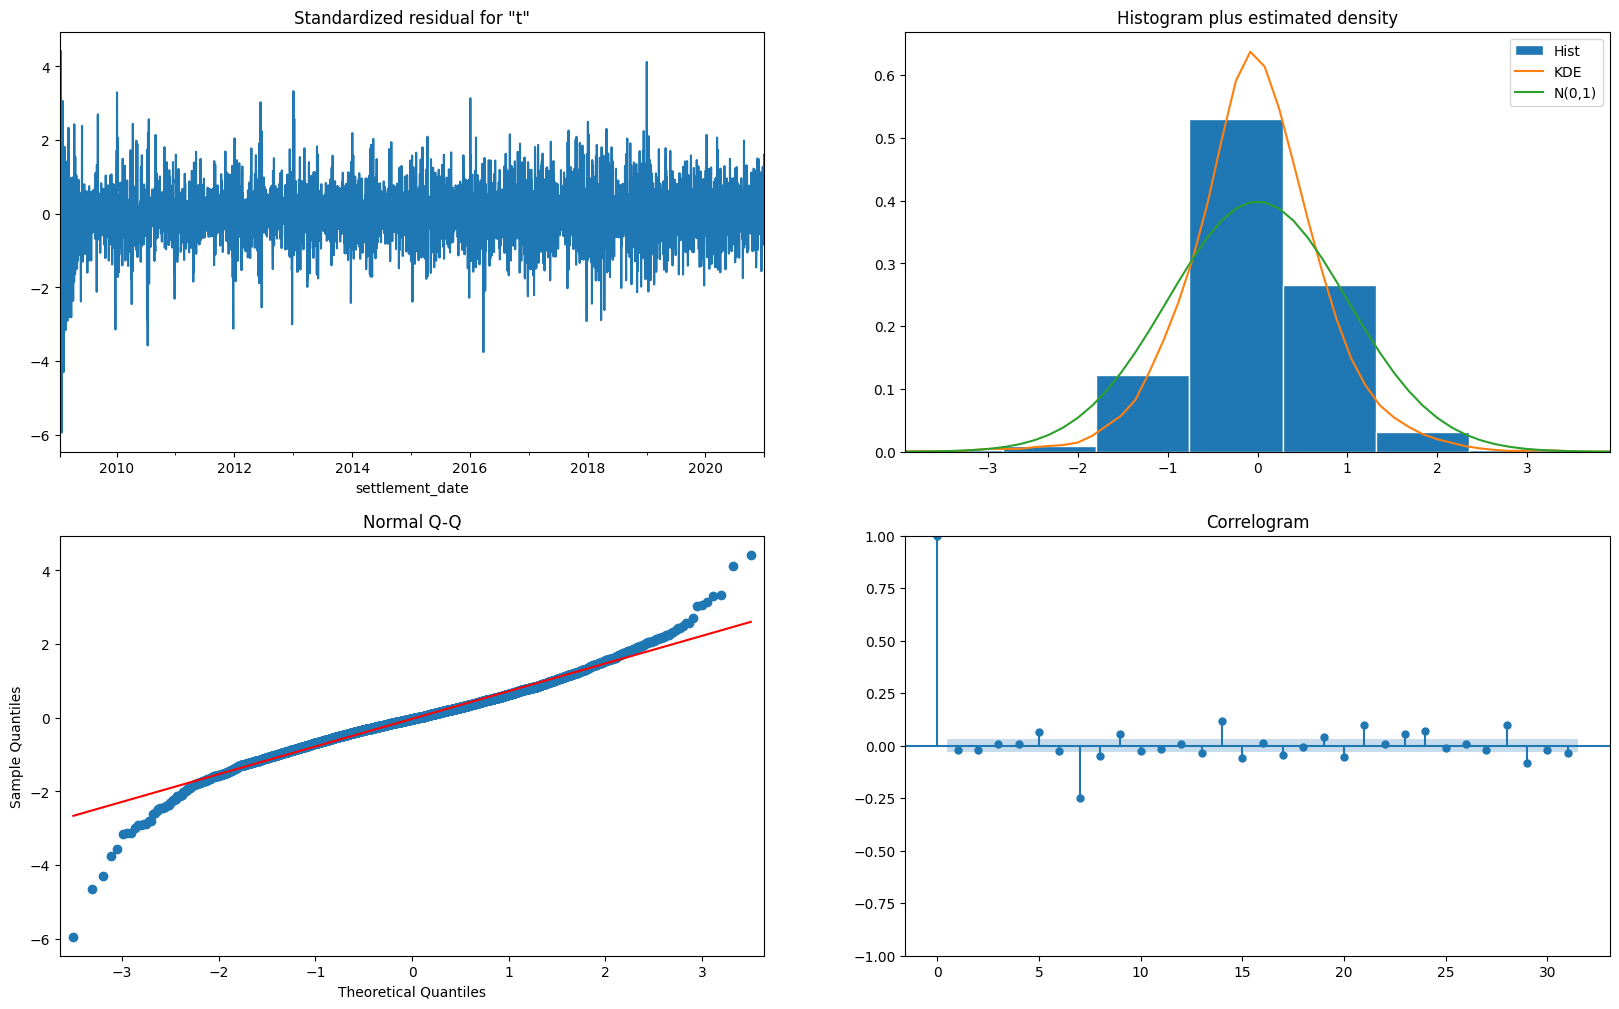

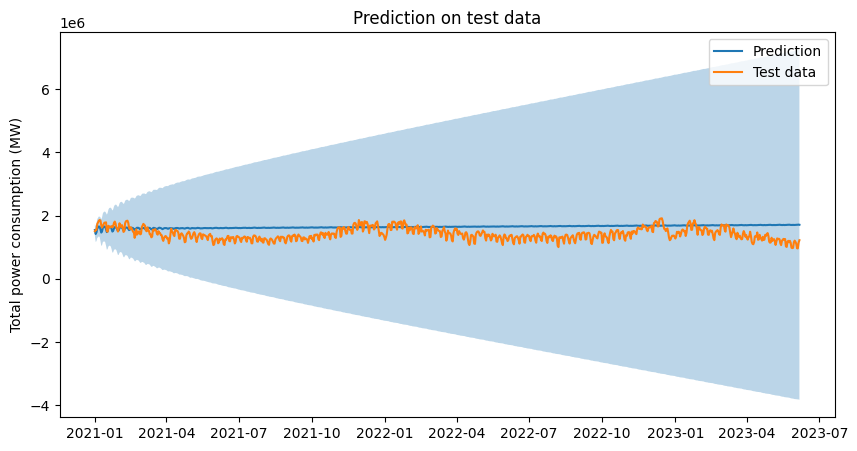

In [ ]:
[execution_time_1, mape_1, sarima_model_1] = create_predict_analyse(
    train_data, (7, 1, 2), (3, 1, 2, 12), 50, 31, test_data, False
)

In [ ]:
print(f"Model 0 MAPE value: {mape_1}")
print(f"Model 0 runtime: {execution_time_1}")

Model 0 MAPE value: 19.779273602712543
Model 0 runtime: 0:05:02.444773


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Normality: val=921.271, p=0.000
Ljung-Box: val=898.988, p=0.000
Heteroskedasticity: val=1.011, p=0.836
Durbin-Watson: d=2.28
-------------------------------------------------------------


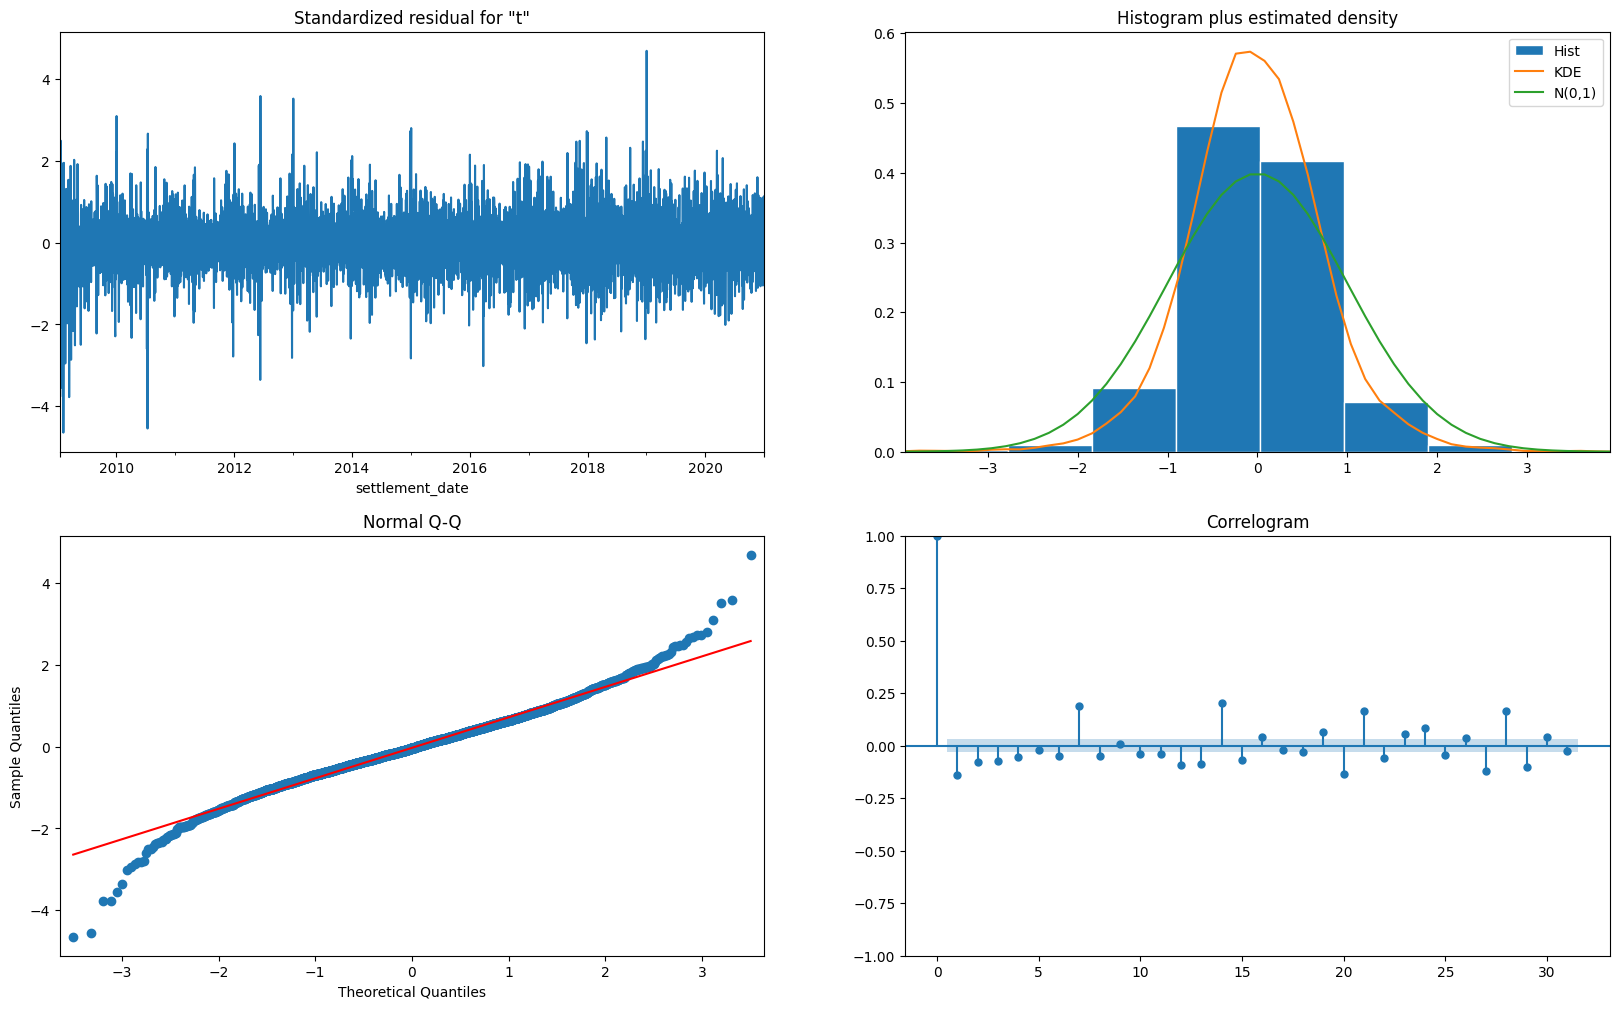

In [ ]:
[execution_time_2, mape_2, sarima_model_2] = create_predict_analyse(
    train_data, (7, 1, 7), (3, 1, 2, 12), 50, 31, test_data, False
)

In [ ]:
print(f"Model 0 MAPE value: {mape_2}")
print(f"Model 0 runtime: {execution_time_2}")

Model 0 MAPE value: 12.457318434710727
Model 0 runtime: 0:05:55.321045


In [ ]:
# [execution_time_3, mape_3, sarima_model_3] = create_predict_analyse(
#     train_data, (7, 1, 7), (9, 1, 2, 12), 25, 31, test_data, True
# )

In [ ]:
df.index

DatetimeIndex(['2009-01-01 00:00:00', '2009-01-01 00:30:00',
               '2009-01-01 01:00:00', '2009-01-01 01:30:00',
               '2009-01-01 02:00:00', '2009-01-01 02:30:00',
               '2009-01-01 03:00:00', '2009-01-01 03:30:00',
               '2009-01-01 04:00:00', '2009-01-01 04:30:00',
               ...
               '2023-06-06 19:00:00', '2023-06-06 19:30:00',
               '2023-06-06 20:00:00', '2023-06-06 20:30:00',
               '2023-06-06 21:00:00', '2023-06-06 21:30:00',
               '2023-06-06 22:00:00', '2023-06-06 22:30:00',
               '2023-06-06 23:00:00', '2023-06-06 23:30:00'],
              dtype='datetime64[ns]', name='settlement_date', length=252210, freq=None)

In [ ]:
threshold_date_1 = "2019-06-01"
threshold_date_2 = "2021-06-01"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

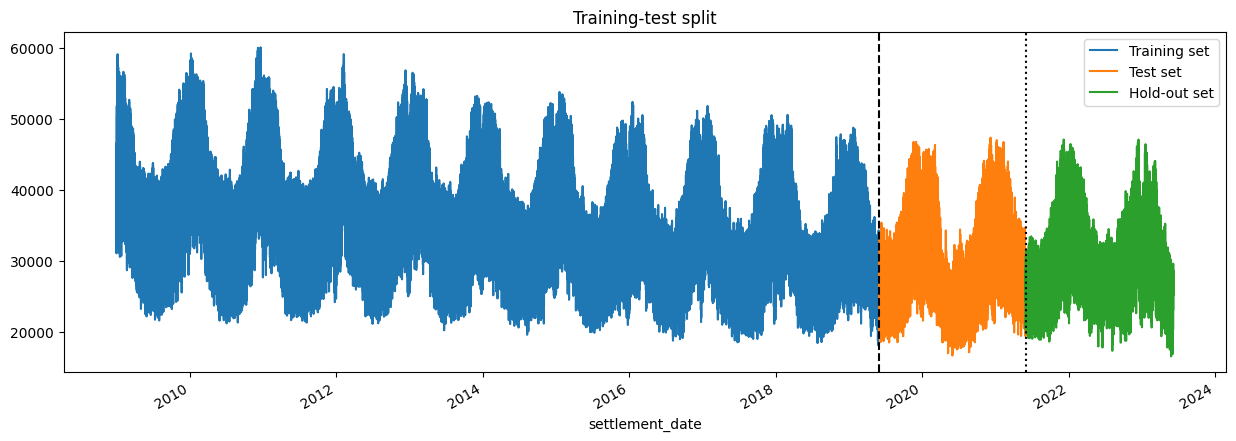

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend()
plt.show()

In [ ]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Initialize and fit the XGBoost model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
#     tree_method="gpu_hist",
    random_state=43,
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
);

[0]	validation_0-rmse:35212.42207	validation_1-rmse:29423.33011
[100]	validation_0-rmse:13523.70887	validation_1-rmse:8860.87405
[200]	validation_0-rmse:5948.39983	validation_1-rmse:3224.31994
[282]	validation_0-rmse:3782.55956	validation_1-rmse:3193.16759


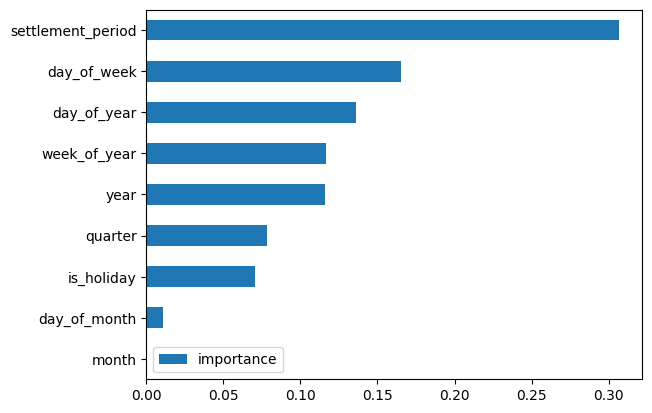

In [ ]:
feat_imp_1 = pd.DataFrame(
    data=xgb_simple.feature_importances_,
    index=xgb_simple.get_booster().feature_names,
    columns=["importance"],
)

feat_imp_1.sort_values("importance", ascending=True, inplace=True)

feat_imp_1.plot(kind="barh")
plt.show()

In [ ]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

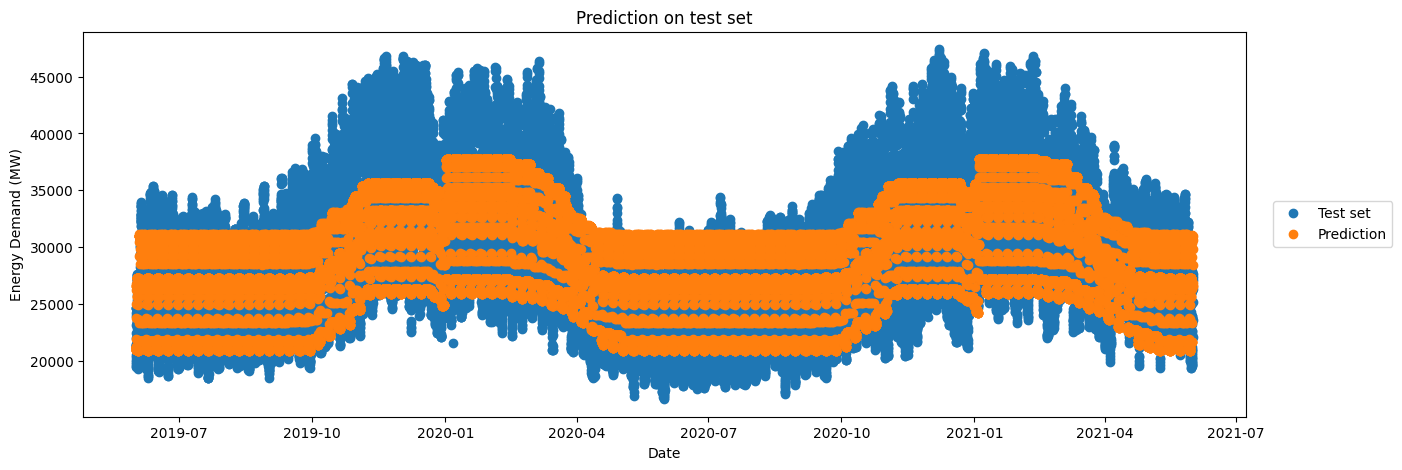

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.show()

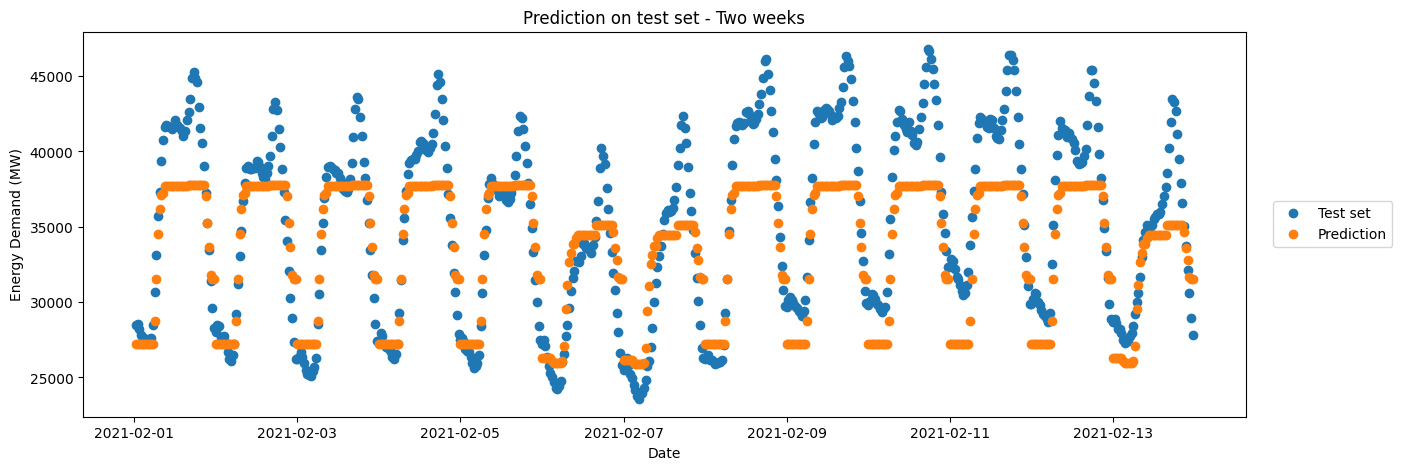

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.show()

In [ ]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 9.00
Root Mean Squared Error of the simple models is: 3345.09 MW


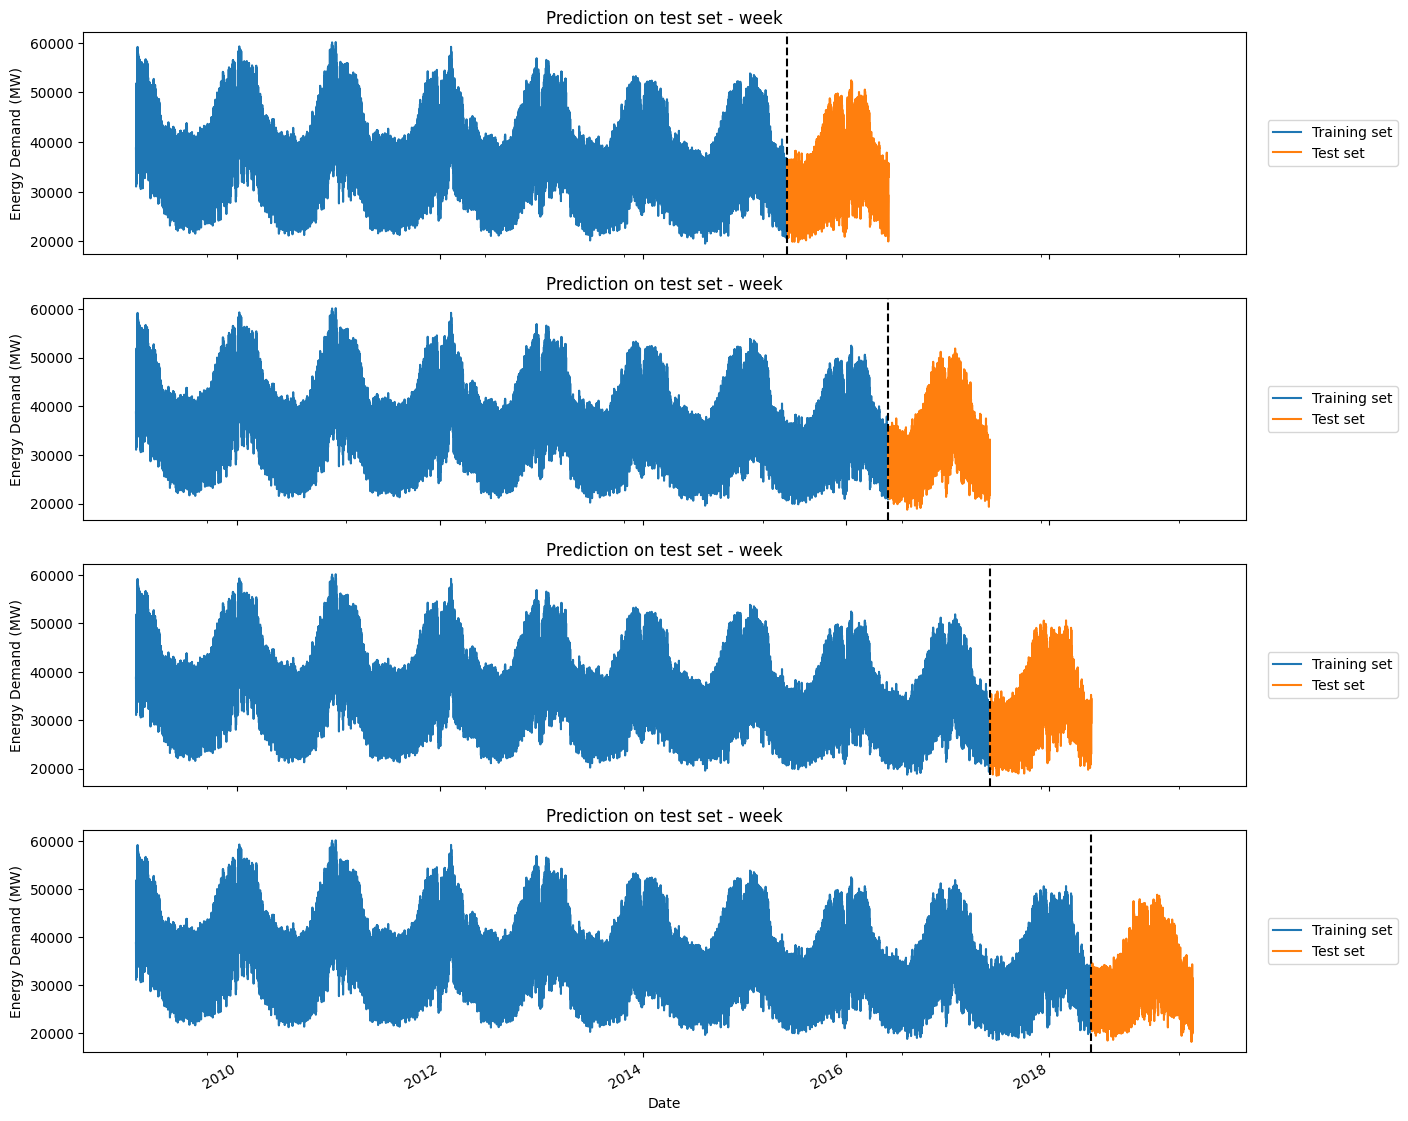

In [ ]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [ ]:
import warnings

def fxn():
    warnings.warn("FutureWarning", FutureWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

In [ ]:
%%time

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "tsd"

# Define train, test and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES_CV]
y_hold_out = hold_out_data[TARGET]


# Define fit parameters to allow early stopping in GridSearchCV
fit_params = {
    "early_stopping_rounds": 50,
    "eval_metric": "rmse",
    "eval_set": [[X_hold_out, y_hold_out]],
}

# Define estimator
estimator = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    learning_rate=0.01,
    tree_method="gpu_hist",
    random_state=43,
)

# Define parameters to optimiser
param_search = {
    "max_depth": [3, 5],
    "n_estimators": [350, 500, 650],
    "subsample": [0.95, 0.8, 0.7],
}


# Create GridSearchCV object
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

xgb_search.fit(X_train_cv, y_train_cv, verbose=500, **fit_params)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[0]	validation_0-rmse:29468.70797
[349]	validation_0-rmse:2465.27242
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2044.026 total time=   2.6s
[0]	validation_0-rmse:29470.45714
[349]	validation_0-rmse:2573.31948
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2568.656 total time=   1.5s
[0]	validation_0-rmse:29471.61478
[349]	validation_0-rmse:2640.59310
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2788.669 total time=   1.1s
[0]	validation_0-rmse:29473.69402
[349]	validation_0-rmse:2614.22454
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2334.863 total time=   0.9s
[0]	validation_0-rmse:29468.66066
[349]	validation_0-rmse:2467.68942
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-2047.250 total time=   1.0s
[0]	validation_0-rmse:29470.62164
[349]	validation_0-rmse:2580.06809
[CV 2/4] END max_depth=3, n_estimators=350, su

GridSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=None, n_splits=4, test_size=17520),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=Non...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=43, ...),
             param_grid={'max_depth': [3, 5], 'n_estimators': [350, 500, 650],
                         'subsample': [0.95, 0.8, 0.7]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
xgb_search.best_params_

{'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}

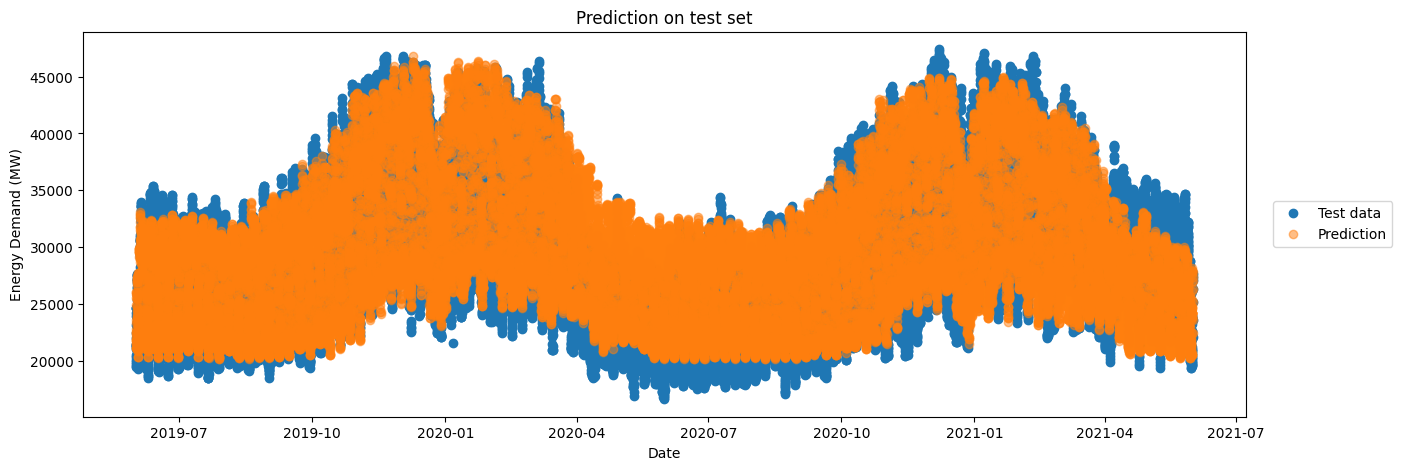

In [ ]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.show()

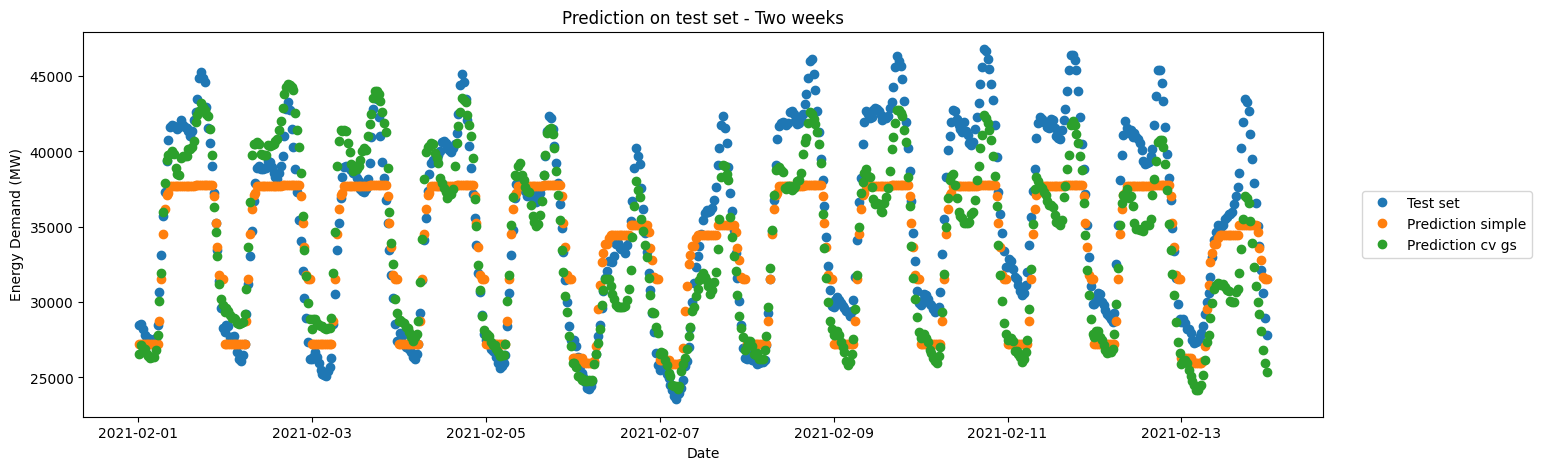

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction simple",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction cv gs",
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.show()

In [ ]:
mape_xgboost_cv = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_cv_gs"]
)

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print(
    "Mean Absolute Percentage Error of the cross-validated model is: %.2f"
    % mape_xgboost_cv
)

print(
    "Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv
)

Mean Absolute Percentage Error of the cross-validated model is: 7.29
Root Mean Squared Error of the cross-validated model is: 2658.33 MW


In [ ]:
X_all = df[FEATURES_CV]
y_all = df[TARGET]

xgb_best = xgb_search.best_estimator_
xgb_best.set_params(n_jobs=-1)
xgb_best.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
    verbose=100,
    early_stopping_rounds=50,
);

[0]	validation_0-rmse:33727.51848
[100]	validation_0-rmse:12589.08838
[200]	validation_0-rmse:5113.25716
[300]	validation_0-rmse:2760.12155
[400]	validation_0-rmse:2136.90001
[499]	validation_0-rmse:1948.57988


In [ ]:
def settlement_period(df):
    """
    Determine settlement period using dataframe index date. Each settlement period
    equates to 30-minute interval.
    Settlement period equal to 0 corresponds with 00:00:00 and settlement period 48
    corresponds with 23:30:00

    Args:
        - df: time series dataframe containing dates in the future

    Returns:
        - df: time series dataframe with settlement period column
    """

    df = df.copy()

    settlement_period_array = (
        np.array(df.index.hour.to_list()) * 2 + np.array(df.index.minute.to_list()) / 30 + 1
    ).astype(int)


    df["settlement_period"] = settlement_period_array

    return df

In [ ]:
prediction_days = 210

future = pd.date_range(
    str(df.index.max())[0:10],
    df.index.max() + timedelta(days=prediction_days),
    freq="30min",
)

future_df = pd.DataFrame(index=future)
future_df = settlement_period(future_df)
future_df["is_future"] = True
df["is_future"] = False

# Create a dataframe containing the original data and the predict df
df_and_future = pd.concat([df, future_df])

# add features and lag
# lag values will change w.r.t original dataframe
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# add bank holidays in future dataframe
df_and_future_wprediction = df_and_future.query("is_future").copy()

df_and_future_wprediction["settlement_date"] = df_and_future_wprediction.index.date
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["is_holiday"].astype(int)

In [ ]:
df_and_future_wprediction.tail()

settlement_period period_hour  nd  tsd  \
2024-01-02 21:30:00                 44         NaT NaN  NaN   
2024-01-02 22:00:00                 45         NaT NaN  NaN   
2024-01-02 22:30:00                 46         NaT NaN  NaN   
2024-01-02 23:00:00                 47         NaT NaN  NaN   
2024-01-02 23:30:00                 48         NaT NaN  NaN   

                     england_wales_demand  embedded_wind_generation  \
2024-01-02 21:30:00                   NaN                       NaN   
2024-01-02 22:00:00                   NaN                       NaN   
2024-01-02 22:30:00                   NaN                       NaN   
2024-01-02 23:00:00                   NaN                       NaN   
2024-01-02 23:30:00                   NaN                       NaN   

                     embedded_wind_capacity  embedded_solar_generation  \
2024-01-02 21:30:00                     NaN                        NaN   
2024-01-02 22:00:00                     NaN                        NaN   
2024-01-02 22:30:00                     NaN                        NaN   
2024-01-02 23:00:00                     NaN                        NaN   
2024-01-02 23:30:00                     NaN                        NaN   

                     embedded_solar_capacity  non_bm_stor  ...  day_of_year  \
2024-01-02 21:30:00                      NaN          NaN  ...            2   
2024-01-02 22:00:00                      NaN          NaN  ...            2   
2024-01-02 22:30:00                      NaN          NaN  ...            2   
2024-01-02 23:00:00                      NaN          NaN  ...            2   
2024-01-02 23:30:00                      NaN          NaN  ...            2   

                     quarter  month  year  week_of_year     lag1     lag2  \
2024-01-02 21:30:00        1      1  2024             1  28287.0  32648.0   
2024-01-02 22:00:00        1      1  2024             1  26966.0  30668.0   
2024-01-02 22:30:00        1      1  2024             1  26027.0  29290.0   
2024-01-02 23:00:00        1      1  2024             1  25720.0  28209.0   
2024-01-02 23:30:00        1      1  2024             1  25199.0  27365.0   

                        lag3  is_future  settlement_date  
2024-01-02 21:30:00  36569.0       True       2024-01-02  
2024-01-02 22:00:00  34415.0       True       2024-01-02  
2024-01-02 22:30:00  32607.0       True       2024-01-02  
2024-01-02 23:00:00  31109.0       True       2024-01-02  
2024-01-02 23:30:00  30683.0       True       2024-01-02  

[5 rows x 30 columns]

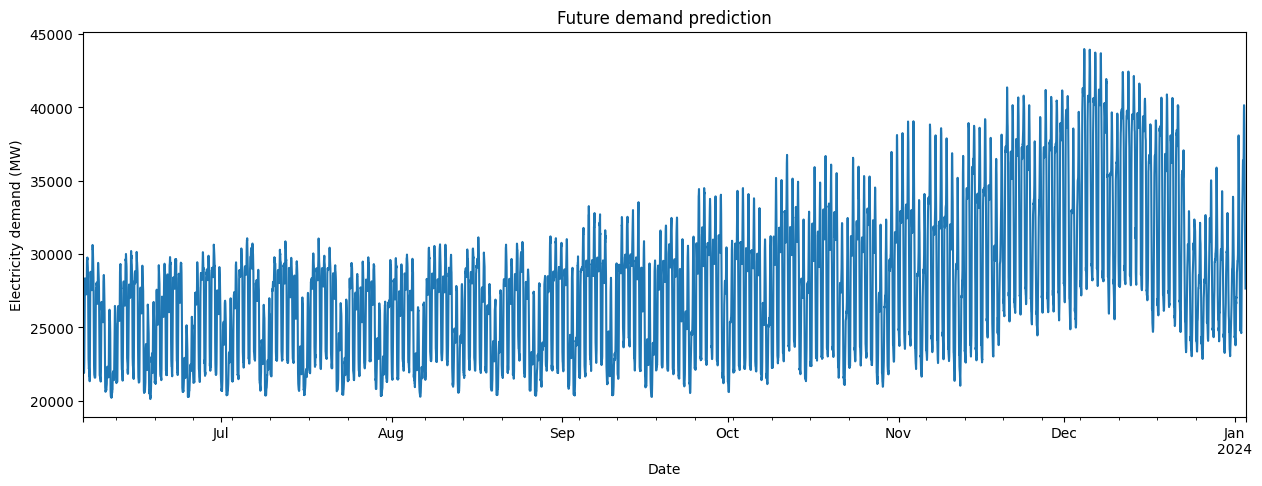

In [ ]:
df_and_future_wprediction["pred_xgboost"] = xgb_best.predict(
    df_and_future_wprediction[FEATURES_CV]
)


fig, ax = plt.subplots(figsize=(15, 5))
df_and_future_wprediction["pred_xgboost"].plot(figsize=(15, 5), style="-", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction")
plt.show()

In [ ]:
%%time
linear_boost = LinearBoostRegressor(
    base_estimator=LinearRegression(n_jobs=-1),
    n_estimators = 350,
    max_depth = 6,
    random_state = 43,
)

linear_boost.fit(X_train, y_train)

result_frame["pred_linear_boost"] = linear_boost.predict(X_test)

CPU times: user 20min 14s, sys: 2min 52s, total: 23min 6s
Wall time: 17min 36s


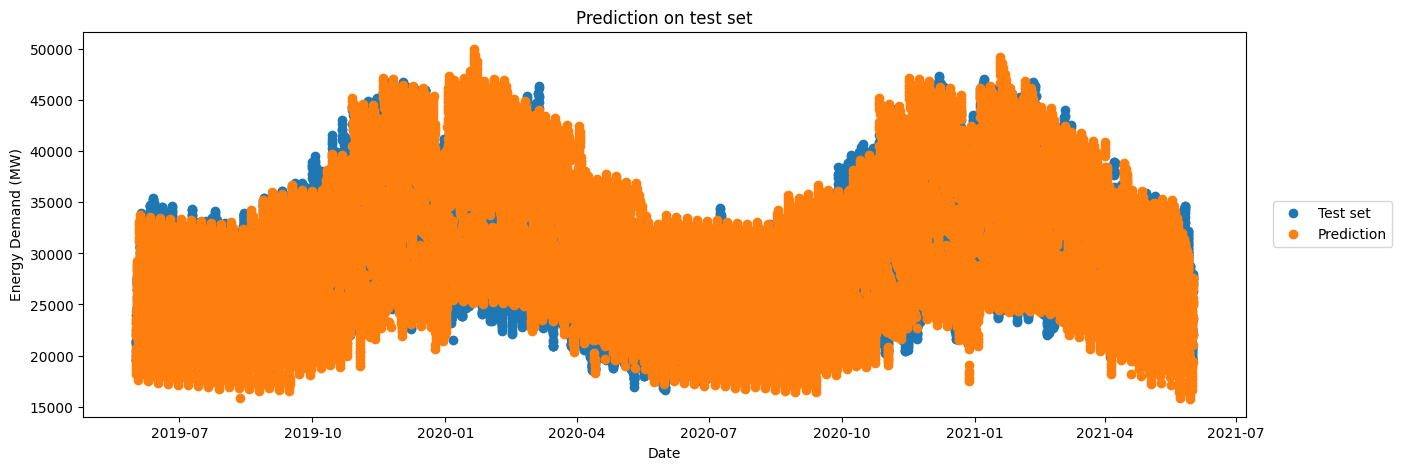

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_linear_boost"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.show()

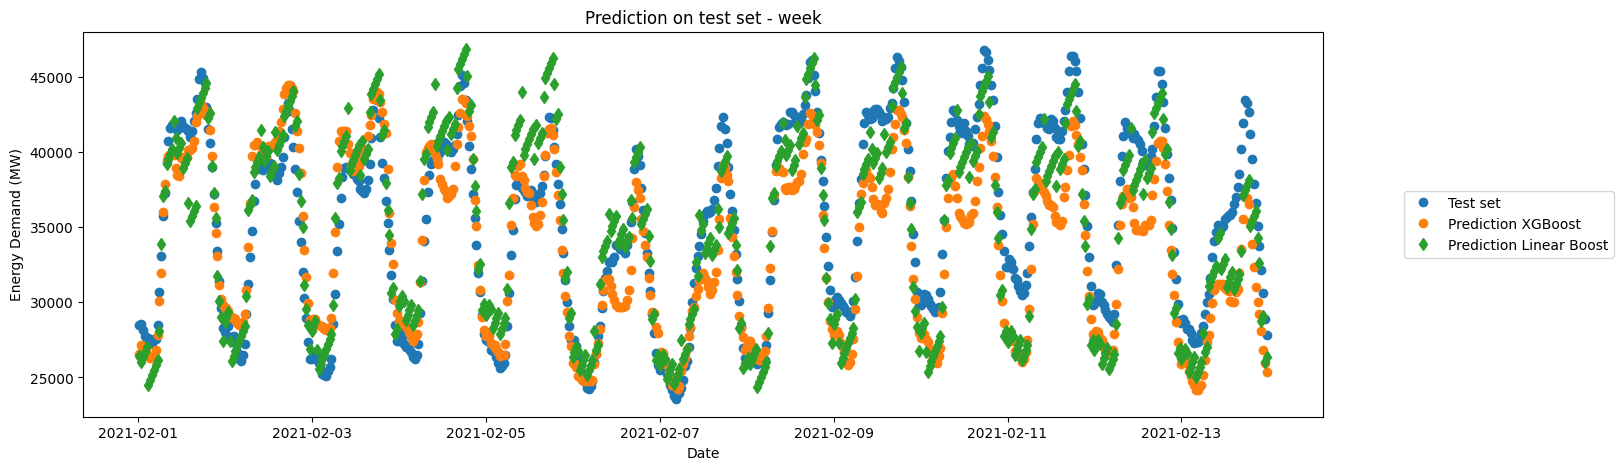

In [ ]:

begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction XGBoost",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_linear_boost"
    ],
    "d",
    label="Prediction Linear Boost",
)

ax.legend(loc="center", bbox_to_anchor=(1.15, 0.5))

ax.set_title("Prediction on test set - week")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.show()

In [ ]:
mape_linear_boost = mean_absolute_percentage_error(
    y_test, result_frame["pred_linear_boost"]
)
rmse_linear_boost = np.sqrt(mean_squared_error(y_test, result_frame["pred_linear_boost"]))

print(
    "Mean Absolute Percentage Error of the Linear Boosted model is: %.2f"
    % mape_linear_boost
)
print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_linear_boost
)

Mean Absolute Percentage Error of the Linear Boosted model is: 8.22
Root Mean Squared Error of the simple models is: 2956.66 MW


In [ ]:
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [ ]:
train_data_prophet = y_train.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
test_data_prophet = y_test.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
hold_out_data_prophet = y_hold_out.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
all_data_prophet = y_all.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

In [ ]:
%%time
prophet_model = Prophet()
prophet_model.fit(train_data_prophet)

np.random.seed(43)
prophet_predict_df = prophet_model.predict(test_data_prophet)
prophet_predict_df.head()

CPU times: user 29.3 s, sys: 2.99 s, total: 32.3 s
Wall time: 4min 29s


ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2019-06-01 00:00:00  30497.233507  16658.673856  23413.052325  30497.233507   
1 2019-06-01 00:30:00  30497.193803  16158.283565  22687.977662  30497.193803   
2 2019-06-01 01:00:00  30497.154100  15658.310066  22314.125422  30497.154100   
3 2019-06-01 01:30:00  30497.114396  15087.206367  21916.331267  30497.114396   
4 2019-06-01 02:00:00  30497.074692  14729.104278  21590.029063  30497.074692   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  30497.233507   -10433.478888         -10433.478888         -10433.478888   
1  30497.193803   -11017.724773         -11017.724773         -11017.724773   
2  30497.154100   -11478.193351         -11478.193351         -11478.193351   
3  30497.114396   -11898.962192         -11898.962192         -11898.962192   
4  30497.074692   -12338.009355         -12338.009355         -12338.009355   

         daily  ...      weekly  weekly_lower  weekly_upper       yearly  \
0 -5634.031441  ... -626.799247   -626.799247   -626.799247 -4172.648199   
1 -6132.512316  ... -712.703056   -712.703056   -712.703056 -4172.509400   
2 -6505.879510  ... -799.945795   -799.945795   -799.945795 -4172.368046   
3 -6838.288313  ... -888.449733   -888.449733   -888.449733 -4172.224147   
4 -7187.798984  ... -978.132659   -978.132659   -978.132659 -4172.077712   

   yearly_lower  yearly_upper  multiplicative_terms  \
0  -4172.648199  -4172.648199                   0.0   
1  -4172.509400  -4172.509400                   0.0   
2  -4172.368046  -4172.368046                   0.0   
3  -4172.224147  -4172.224147                   0.0   
4  -4172.077712  -4172.077712                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  20063.754619  
1                         0.0                         0.0  19479.469030  
2                         0.0                         0.0  19018.960748  
3                         0.0                         0.0  18598.152204  
4                         0.0                         0.0  18159.065337  

[5 rows x 22 columns]

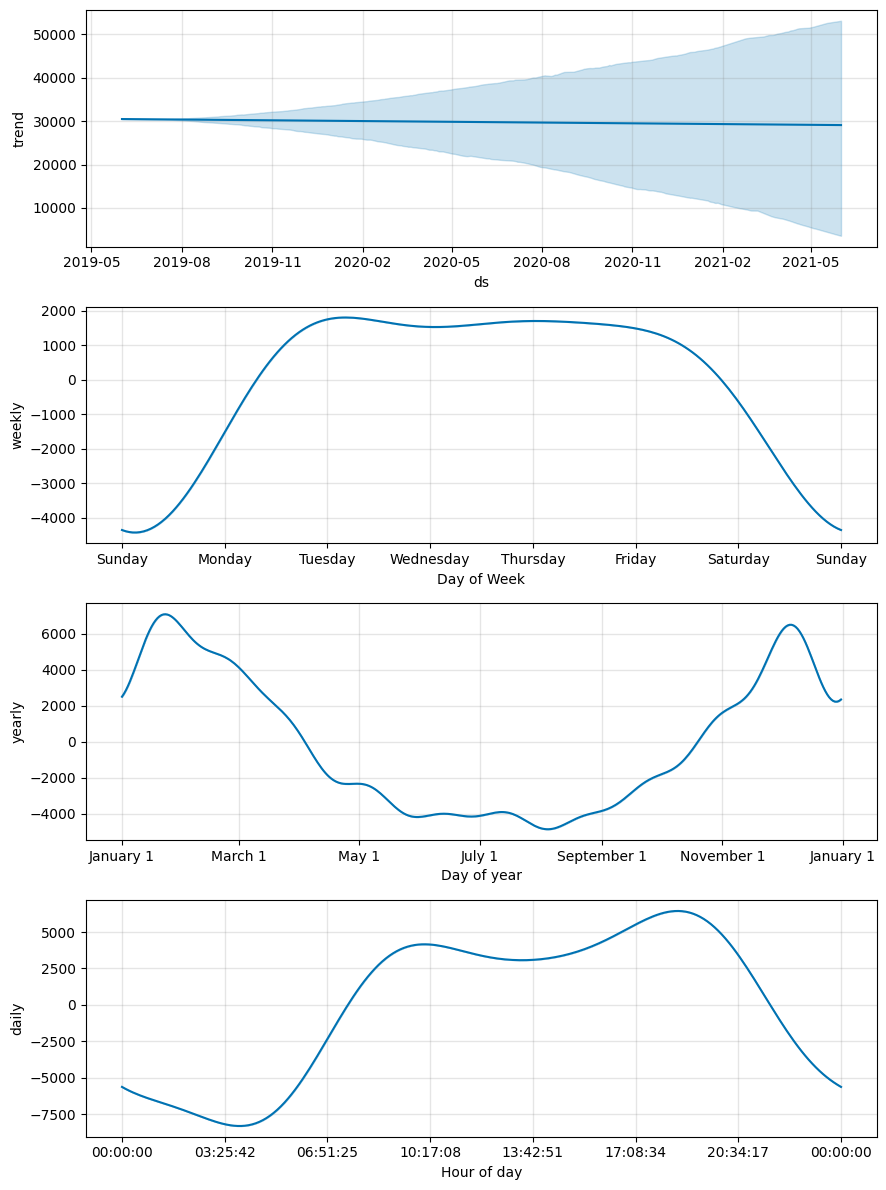

In [ ]:
prophet_model.plot_components(prophet_predict_df)

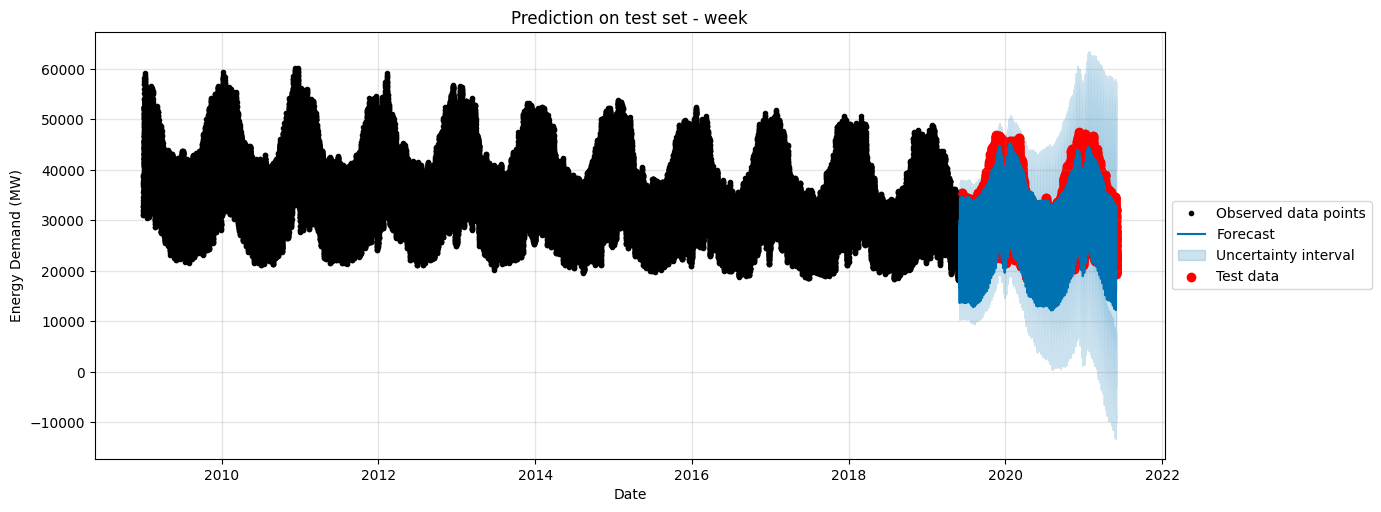

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set - week")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.show()

In [ ]:
y_test.to_frame().index

DatetimeIndex(['2019-06-01 00:00:00', '2019-06-01 00:30:00',
               '2019-06-01 01:00:00', '2019-06-01 01:30:00',
               '2019-06-01 02:00:00', '2019-06-01 02:30:00',
               '2019-06-01 03:00:00', '2019-06-01 03:30:00',
               '2019-06-01 04:00:00', '2019-06-01 04:30:00',
               ...
               '2021-05-31 19:00:00', '2021-05-31 19:30:00',
               '2021-05-31 20:00:00', '2021-05-31 20:30:00',
               '2021-05-31 21:00:00', '2021-05-31 21:30:00',
               '2021-05-31 22:00:00', '2021-05-31 22:30:00',
               '2021-05-31 23:00:00', '2021-05-31 23:30:00'],
              dtype='datetime64[ns]', name='settlement_date', length=35084, freq=None)

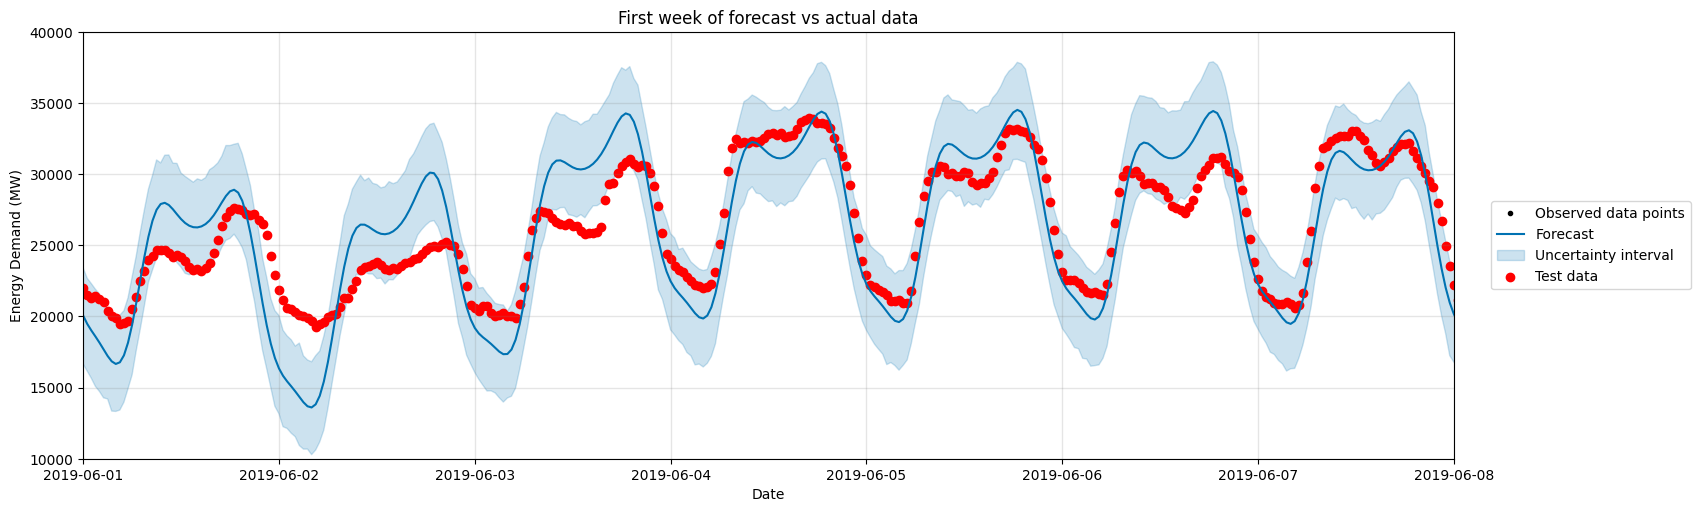

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.set_xbound(lower=pd.to_datetime('2019-06-01', format = '%Y-%m-%d'), upper=pd.to_datetime('2019-06-08', format = '%Y-%m-%d'))
ax.set_ylim(bottom=10000, top=40000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("First week of forecast vs actual data")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

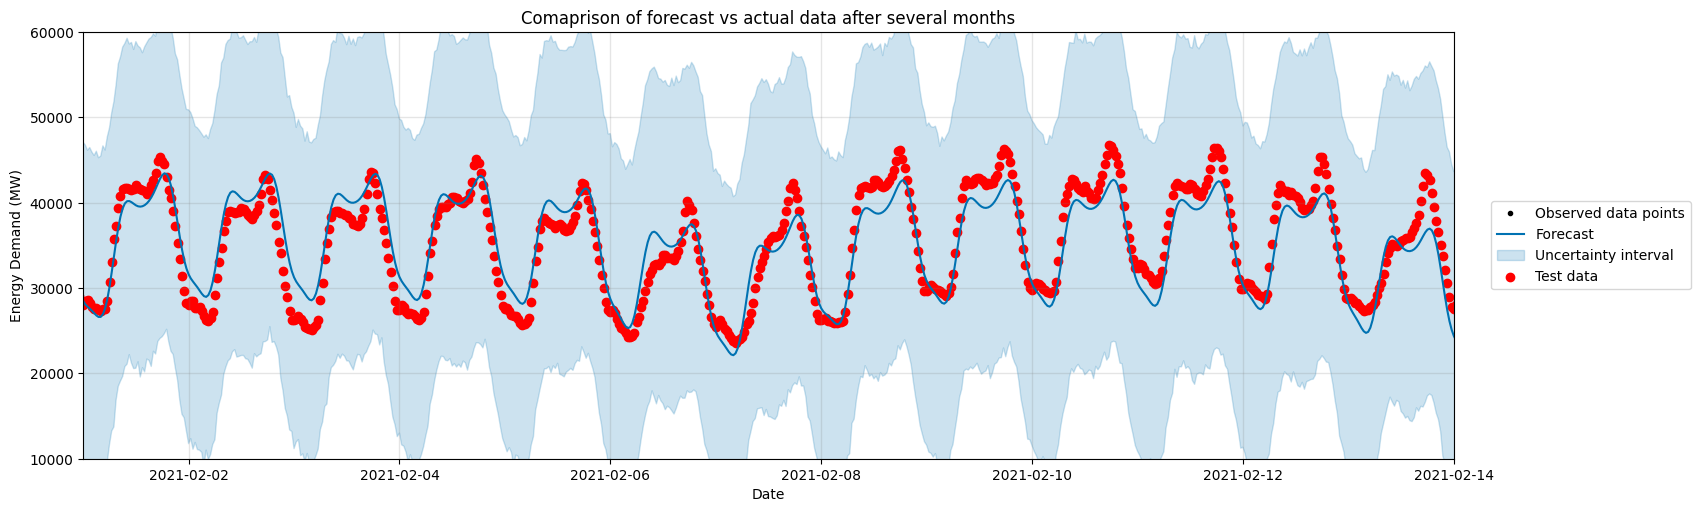

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.set_xbound(lower=pd.to_datetime('2021-02-01', format = '%Y-%m-%d'), upper=pd.to_datetime('2021-02-14', format = '%Y-%m-%d'))
ax.set_ylim(bottom=10000, top=60000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Comaprison of forecast vs actual data after several months")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.show()

In [ ]:
%%time
mape_prophet_simple = mean_absolute_percentage_error(
    y_test, prophet_predict_df["yhat"]
)
rmse_prophet_simple = np.sqrt(mean_squared_error(y_test, prophet_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error of the simple Prophet model is: %.2f"
    % mape_prophet_simple
)
print(
    "Root Mean Squared Error of the simple Prophet models is: %.2f MW" % rmse_prophet_simple
)

Mean Absolute Percentage Error of the simple Prophet model is: 9.36
Root Mean Squared Error of the simple Prophet models is: 3256.72 MW
CPU times: user 3.1 ms, sys: 64 µs, total: 3.16 ms
Wall time: 2.76 ms


In [ ]:
holiday_df = pd.DataFrame(data={"ds": holiday_dates_observed, "holiday": holiday_names_observed})
holiday_df.head()

ds              holiday
0 2009-01-01       New Year's Day
1 2009-04-10          Good Friday
2 2009-04-13        Easter Monday
3 2009-05-04              May Day
4 2009-05-25  Spring Bank Holiday

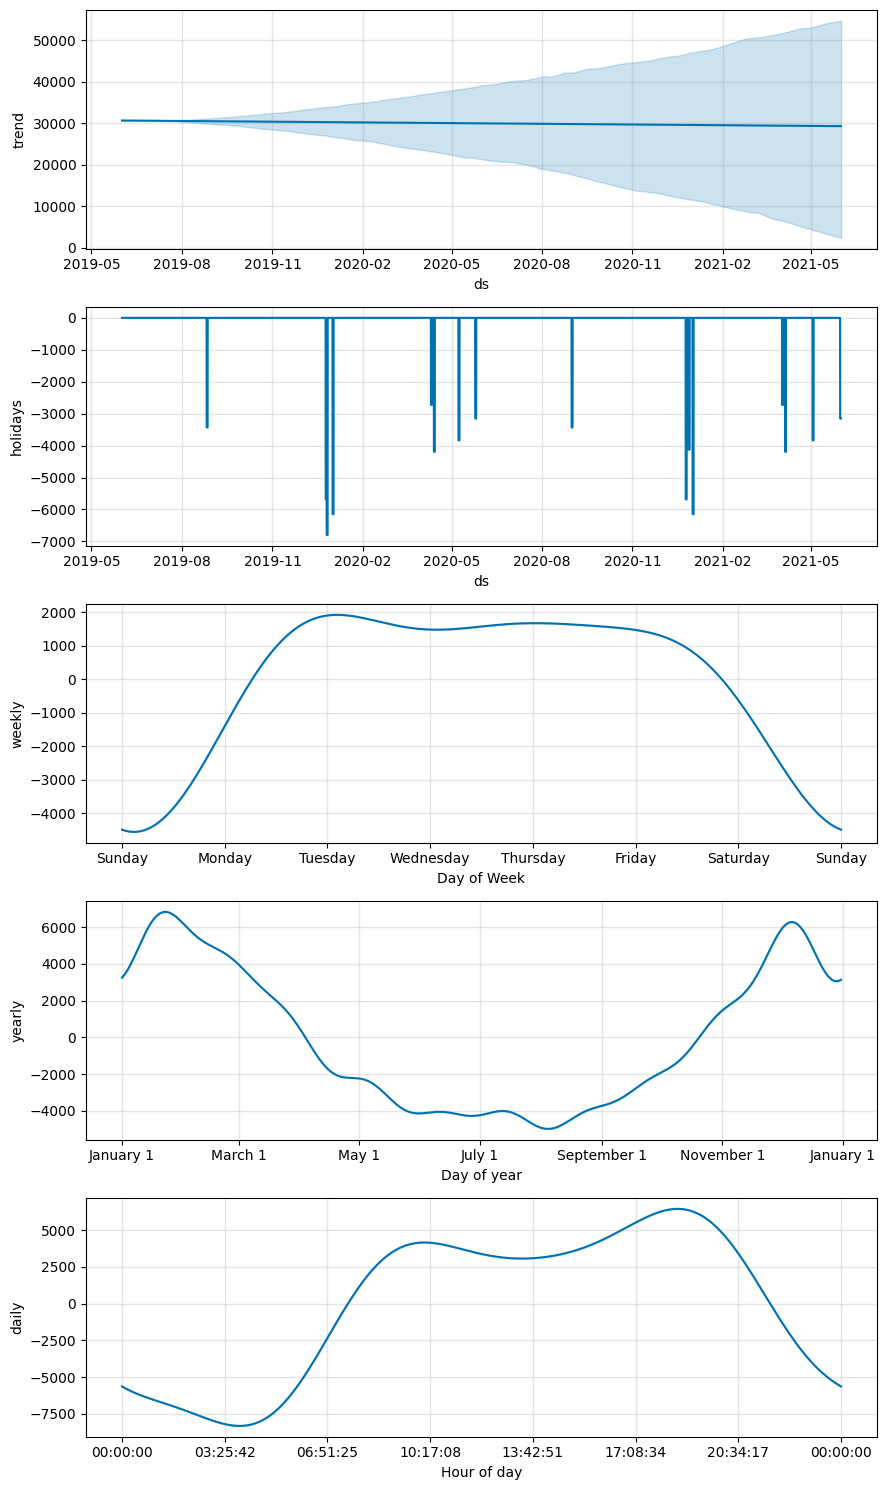

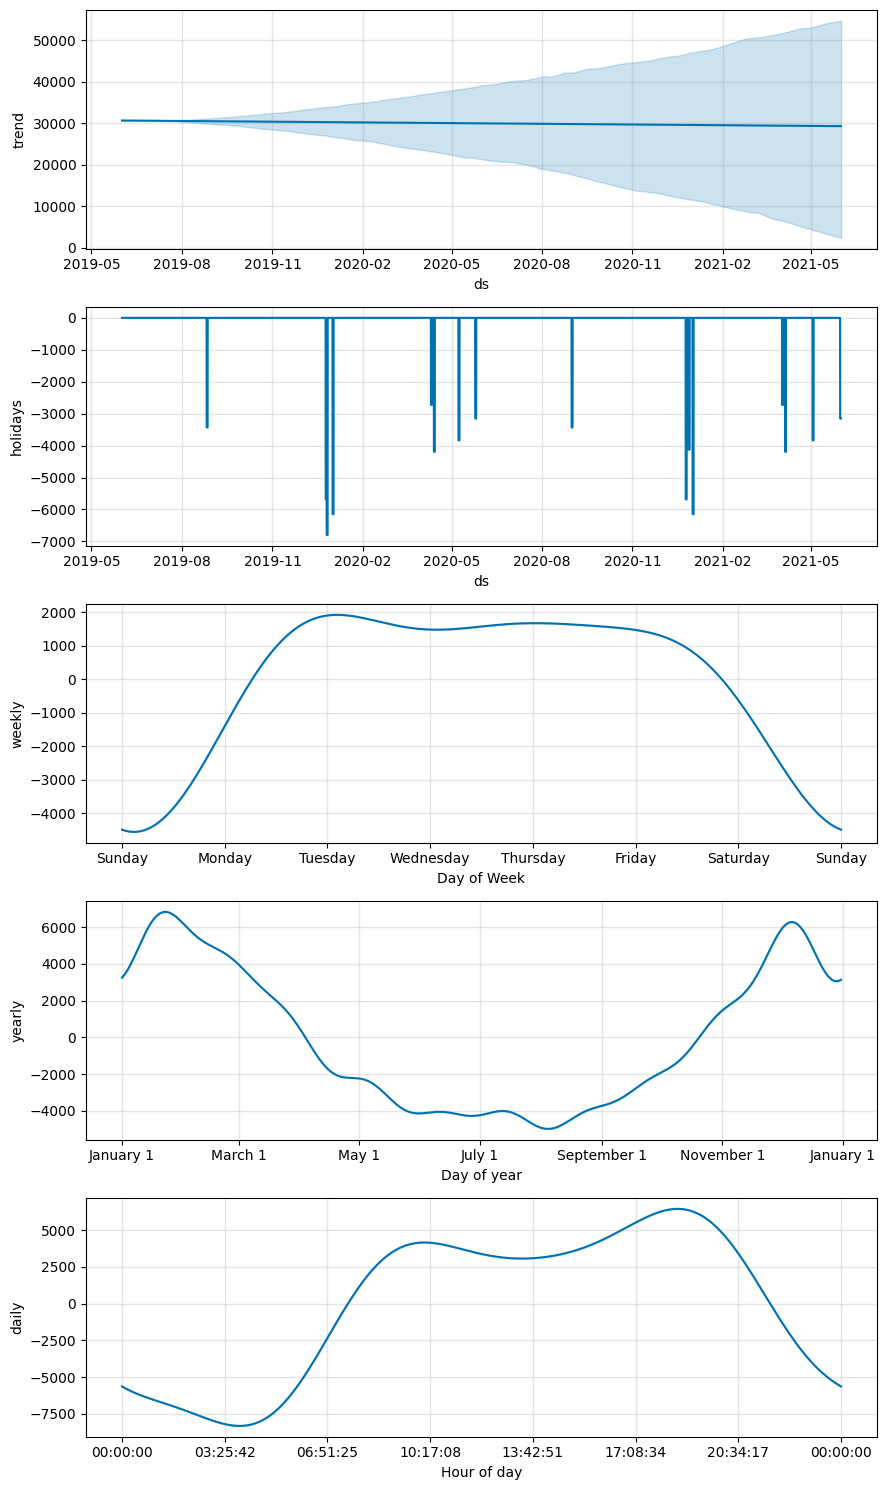

In [ ]:
prophet_hol_model = Prophet(holidays=holiday_df)
prophet_hol_model.fit(train_data_prophet)

np.random.seed(43)
prophet_hol_predict_df = prophet_hol_model.predict(test_data_prophet)
prophet_hol_model.plot_components(prophet_hol_predict_df)

Text(0.5, 25.722222222222214, 'Date')

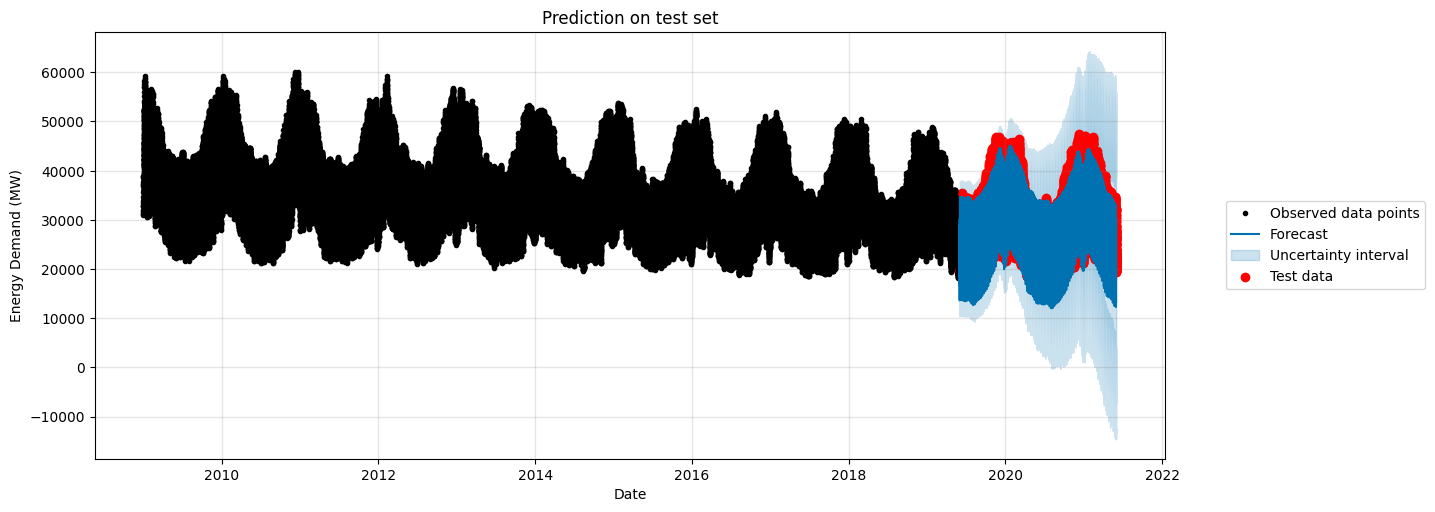

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_hol_model.plot(prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.15, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")

Text(0.5, 25.722222222222214, 'Date')

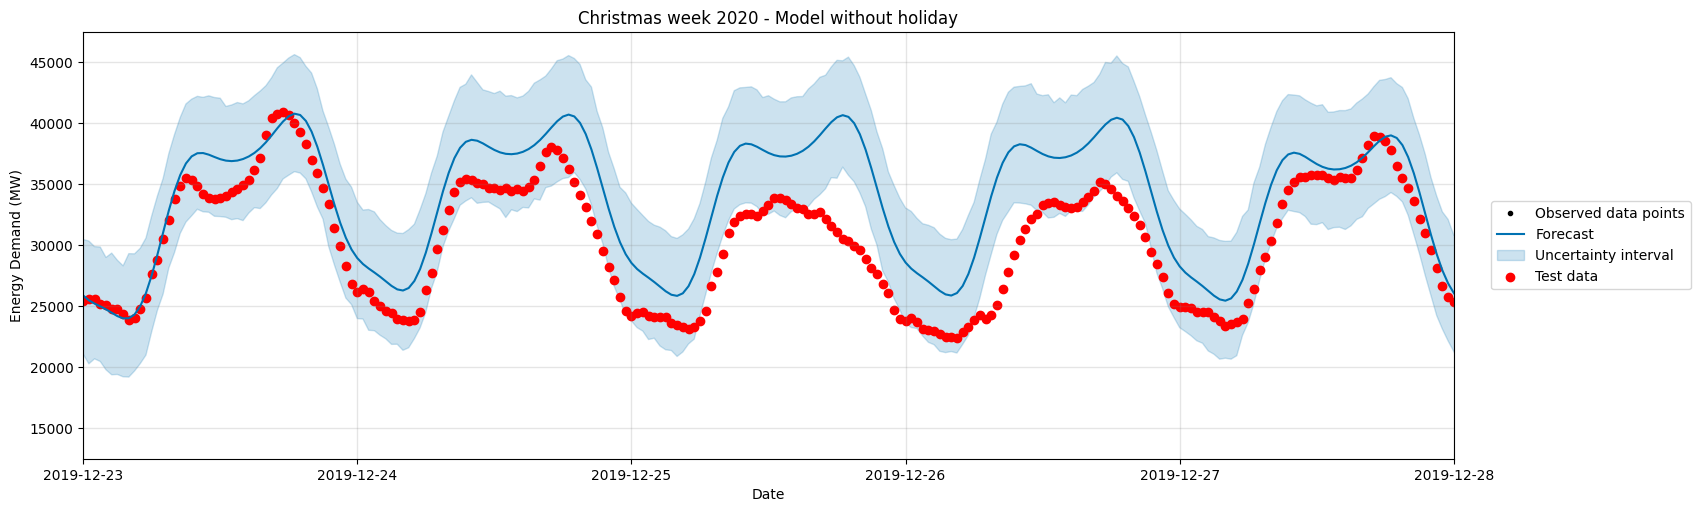

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.set_xlim(left=pd.to_datetime("2019-12-23", format = '%Y-%m-%d'), right= pd.to_datetime("2019-12-28", format = '%Y-%m-%d') )
ax.set_ylim(bottom=12500, top=47500)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Christmas week 2020 - Model without holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.set_xlim(left=pd.to_datetime("2019-12-23", format = '%Y-%m-%d'), right= pd.to_datetime("2019-12-28", format = '%Y-%m-%d'))
ax.set_ylim(bottom=12500, top=47500)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Christmas week 2020 - Model with holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
mape_prophet_holiday = mean_absolute_percentage_error(
    y_test, prophet_hol_predict_df["yhat"]
)
rmse_prophet_holiday = np.sqrt(mean_squared_error(y_test, prophet_hol_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error of the holiday Prophet model is: %.2f"
    % mape_prophet_holiday
)
print(
    "Root Mean Squared Error of the Prophet (with holiday) model is: %.2f MW" % rmse_prophet_holiday
)

Mean Absolute Percentage Error of the holiday Prophet model is: 9.36
Root Mean Squared Error of the Prophet (with holiday) model is: 3241.48 MW


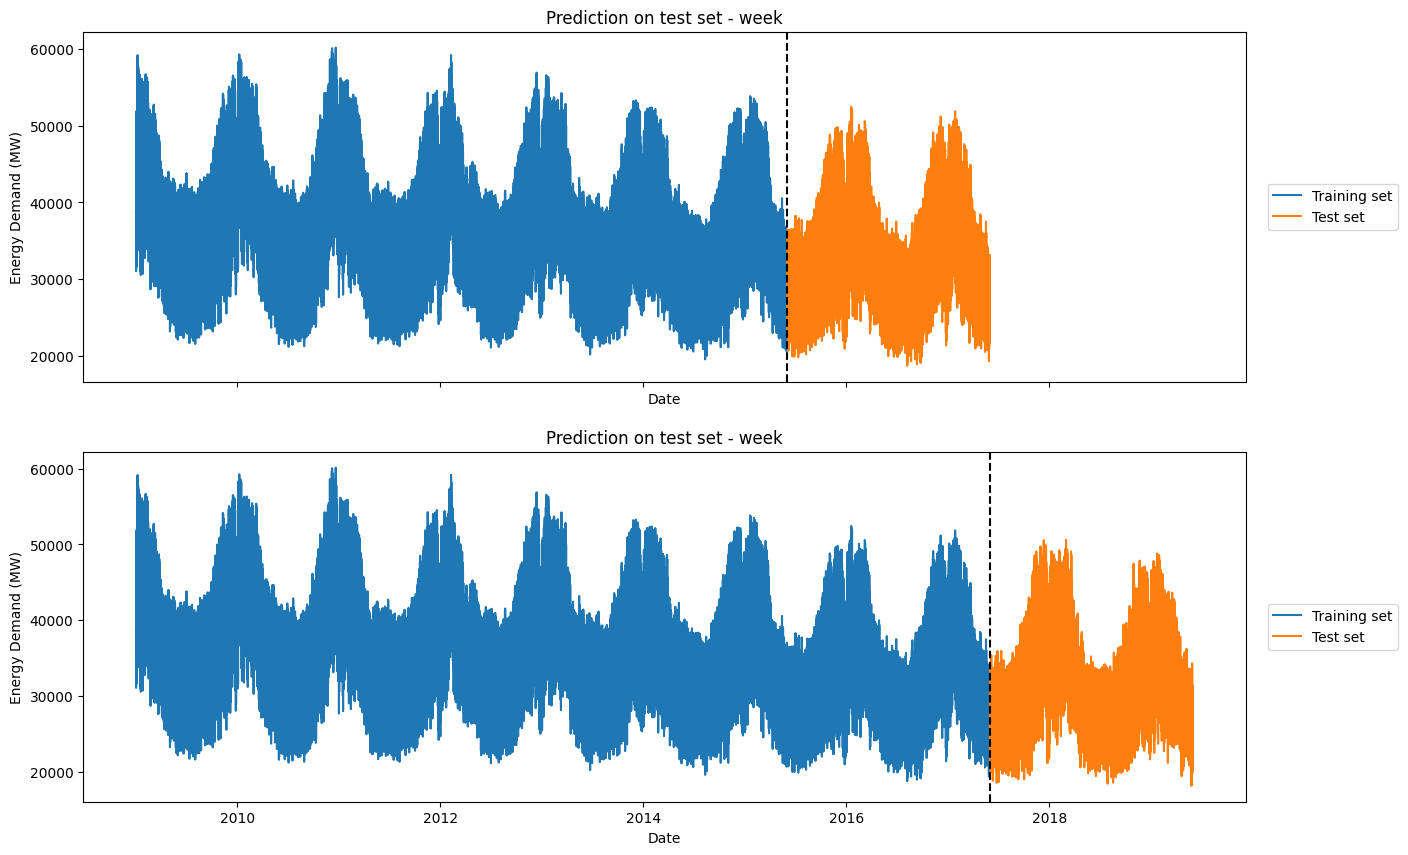

In [ ]:
n_years_test = 2
tss_prophet = TimeSeriesSplit(n_splits=2, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

fold = 0
for train_index, test_index in tss_prophet.split(df[df.index<threshold_date_1]):
    train_data = y_train.to_frame() \
                        .reset_index() \
                        .iloc[train_index] \
                        .rename(columns={"settlement_date": "ds", "tsd": "y"})

    test_data = y_train.to_frame() \
                    .reset_index() \
                    .iloc[test_index] \
                    .rename(columns={"settlement_date": "ds", "tsd": "y"})

    axes[fold].plot(train_data["ds"], train_data["y"], label="Training set")
    axes[fold].plot(test_data["ds"], test_data["y"], label="Test set")
    axes[fold].axvline(test_data["ds"].min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [ ]:
%%time

# Define the parameter grid for the Prophet model
param_grid = {"changepoint_prior_scale": [0.05], "seasonality_prior_scale": [2.5, 10]}

# Create all possible combinations of the parameter grid
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

rmse_cv_gs = []

for params in all_params:
    rmse_cv = []

    for train_index, test_index in tss_prophet.split(df[df.index<threshold_date_1]):
        train_data = y_train.to_frame() \
                            .reset_index() \
                            .iloc[train_index] \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

        test_data = y_train.to_frame() \
                            .reset_index() \
                            .iloc[test_index] \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

        model = Prophet(**params, holidays=holiday_df)
        model.fit(train_data)

        prediction = model.predict(test_data)
        mse_val = mean_squared_error(test_data["y"], prediction["yhat"])
        rmse_cv.append(np.sqrt(mse_val))

    rmse_cv_gs.append(np.mean(rmse_cv))

grid_search_results = pd.DataFrame(all_params)
grid_search_results['rmse'] = rmse_cv_gs

grid_search_results

CPU times: user 1min 21s, sys: 9.11 s, total: 1min 31s
Wall time: 10min 27s


changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.05                      2.5  2919.939911
1                     0.05                     10.0  2926.725788

In [ ]:
best_params = all_params[np.argmin(rmse_cv_gs)]
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 2.5}


In [ ]:
# Create Prophet using the best parameters from the grid search
prophet_best = Prophet(**best_params, holidays=holiday_df)
prophet_best.fit(train_data_prophet)

prophet_best_predict_df = prophet_best.predict(test_data_prophet)

# Compute MAPE value
mape_prophet_cv_gs = mean_absolute_percentage_error(
    y_test, prophet_best_predict_df["yhat"]
)
rmse_prophet_cv_gs = np.sqrt(
    mean_squared_error(y_test, prophet_best_predict_df["yhat"])
)
print(
    "Mean Absolute Percentage Error of the best-parameters Prophet model is: %.2f"
    % mape_prophet_cv_gs
)
print(
    "Root Mean Squared Error of the Prophet (with cross-validation) model is: %.2f MW" % rmse_prophet_cv_gs
)

Mean Absolute Percentage Error of the best-parameters Prophet model is: 9.35
Root Mean Squared Error of the Prophet (with cross-validation) model is: 3240.26 MW


In [ ]:
# Fit a new model using all the data as training data
prophet_future_model = Prophet(**best_params, holidays=holiday_df)
prophet_future_model.fit(all_data_prophet)

# Make predictions on future dataframe
prophet_future = prophet_future_model.make_future_dataframe(periods=210*24, freq="H", include_history=False)
prophet_fut_forecast = prophet_future_model.predict(prophet_future)

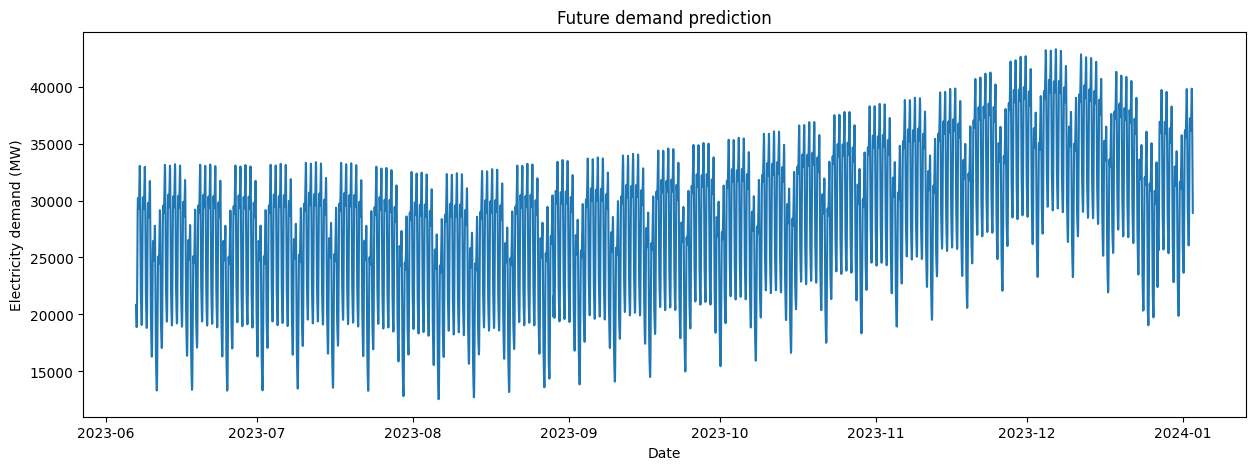

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(prophet_fut_forecast["ds"], prophet_fut_forecast["yhat"])

ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction")
plt.show()

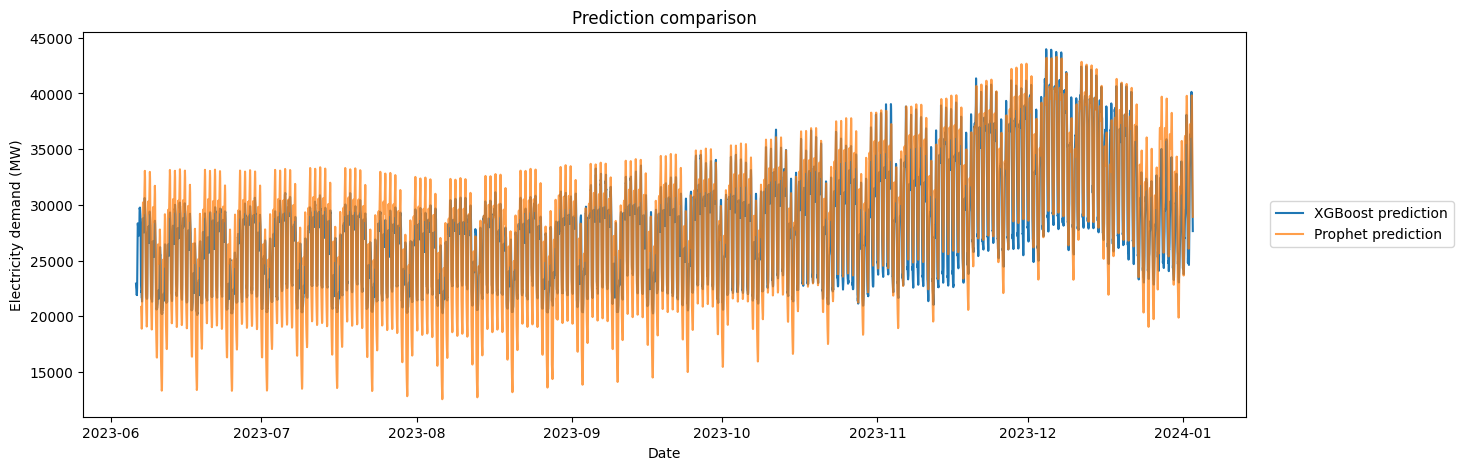

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(
        df_and_future_wprediction.index,
        df_and_future_wprediction["pred_xgboost"],
        label = "XGBoost prediction"
        )
ax.plot(
        prophet_fut_forecast["ds"],
        prophet_fut_forecast["yhat"],
        label = "Prophet prediction",
        alpha = 0.75
        )

ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Prediction comparison")

ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)
plt.show()

In [ ]:
# Define rmse metric for keras to use as a loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0,1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = (
    train_data_keras_s[:,:-1].
    reshape(train_data_keras_s.shape[0],1,len(FEATURES))
)
y_train_keras = train_data_keras_s[:,-1]

X_test_keras = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(FEATURES))
)
y_test_keras = test_data_keras_s[:,-1]

In [ ]:
# Define a random seed for reproducibility
tf.random.set_seed(221)

# Create and compite neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = loss, optimizer="adam")

# Define callbacks
monitor_param = 'loss'
mode="min"
early_stopping = EarlyStopping(monitor='loss', patience=8, verbose=0, mode=mode)
checkpoint_save = ModelCheckpoint(
    "../models_data/simple_lstm/checkpoint",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss]
)

Epoch 1/100
1256/1263 [============================>.] - ETA: 0s - loss: 0.1302

1263/1263 [==============================] - 17s 6ms/step - loss: 0.1301 - val_loss: 0.0964 - lr: 0.0010
Epoch 2/100
1259/1263 [============================>.] - ETA: 0s - loss: 0.1035

1263/1263 [==============================] - 10s 8ms/step - loss: 0.1035 - val_loss: 0.0902 - lr: 0.0010
Epoch 3/100
1257/1263 [============================>.] - ETA: 0s - loss: 0.0960

1263/1263 [==============================] - 9s 7ms/step - loss: 0.0960 - val_loss: 0.0867 - lr: 0.0010
Epoch 4/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0915

1263/1263 [==============================] - 8s 7ms/step - loss: 0.0915 - val_loss: 0.0869 - lr: 0.0010
Epoch 5/100
1255/1263 [============================>.] - ETA: 0s - loss: 0.0887

1263/1263 [==============================] - 8s 6ms/step - loss: 0.0887 - val_loss: 0.0814 - lr: 0.0010
Epoch 6/100
1251/1263 [============================>.] - ETA: 0s - loss: 0.0866

1263/1263 [==============================] - 8s 6ms/step - loss: 0.0866 - val_loss: 0.0809 - lr: 0.0010
Epoch 7/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0852

1263/1263 [==============================] - 8s 7ms/step - loss: 0.0852 - val_loss: 0.0797 - lr: 0.0010
Epoch 8/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0841

1263/1263 [==============================] - 8s 7ms/step - loss: 0.0841 - val_loss: 0.0802 - lr: 0.0010
Epoch 9/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0833

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0833 - val_loss: 0.0790 - lr: 0.0010
Epoch 10/100
1252/1263 [============================>.] - ETA: 0s - loss: 0.0825

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0826 - val_loss: 0.0800 - lr: 0.0010
Epoch 11/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0819

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0819 - val_loss: 0.0779 - lr: 0.0010
Epoch 12/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0815

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0815 - val_loss: 0.0776 - lr: 0.0010
Epoch 13/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0813

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0812 - val_loss: 0.0783 - lr: 0.0010
Epoch 14/100
1258/1263 [============================>.] - ETA: 0s - loss: 0.0809

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0809 - val_loss: 0.0773 - lr: 0.0010
Epoch 15/100
1253/1263 [============================>.] - ETA: 0s - loss: 0.0805

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0805 - val_loss: 0.0788 - lr: 0.0010
Epoch 16/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0804

1263/1263 [==============================] - 7s 6ms/step - loss: 0.0804 - val_loss: 0.0788 - lr: 0.0010
Epoch 17/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0801

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0801 - val_loss: 0.0770 - lr: 0.0010
Epoch 18/100
1253/1263 [============================>.] - ETA: 0s - loss: 0.0800

1263/1263 [==============================] - 7s 5ms/step - loss: 0.0800 - val_loss: 0.0775 - lr: 0.0010
Epoch 19/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0798

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0798 - val_loss: 0.0765 - lr: 0.0010
Epoch 20/100
1258/1263 [============================>.] - ETA: 0s - loss: 0.0796

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0796 - val_loss: 0.0775 - lr: 0.0010
Epoch 21/100
1255/1263 [============================>.] - ETA: 0s - loss: 0.0796

1263/1263 [==============================] - 9s 7ms/step - loss: 0.0796 - val_loss: 0.0775 - lr: 0.0010
Epoch 22/100
1253/1263 [============================>.] - ETA: 0s - loss: 0.0795

1263/1263 [==============================] - 8s 7ms/step - loss: 0.0795 - val_loss: 0.0766 - lr: 0.0010
Epoch 23/100
1259/1263 [============================>.] - ETA: 0s - loss: 0.0793

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0793 - val_loss: 0.0767 - lr: 0.0010
Epoch 24/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0792

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0792 - val_loss: 0.0771 - lr: 0.0010
Epoch 25/100
1254/1263 [============================>.] - ETA: 0s - loss: 0.0791

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0792 - val_loss: 0.0758 - lr: 0.0010
Epoch 26/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0789

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0789 - val_loss: 0.0761 - lr: 0.0010
Epoch 27/100
1259/1263 [============================>.] - ETA: 0s - loss: 0.0786

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0786 - val_loss: 0.0751 - lr: 0.0010
Epoch 28/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0785

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0785 - val_loss: 0.0753 - lr: 0.0010
Epoch 29/100
1251/1263 [============================>.] - ETA: 0s - loss: 0.0784

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0784 - val_loss: 0.0747 - lr: 0.0010
Epoch 30/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0783

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0783 - val_loss: 0.0747 - lr: 0.0010
Epoch 31/100
1252/1263 [============================>.] - ETA: 0s - loss: 0.0781

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0781 - val_loss: 0.0749 - lr: 0.0010
Epoch 32/100
1257/1263 [============================>.] - ETA: 0s - loss: 0.0779

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0779 - val_loss: 0.0748 - lr: 0.0010
Epoch 33/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0778

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0778 - val_loss: 0.0747 - lr: 0.0010
Epoch 34/100
1257/1263 [============================>.] - ETA: 0s - loss: 0.0775

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0775 - val_loss: 0.0739 - lr: 0.0010
Epoch 35/100
1253/1263 [============================>.] - ETA: 0s - loss: 0.0774

1263/1263 [==============================] - 7s 5ms/step - loss: 0.0774 - val_loss: 0.0745 - lr: 0.0010
Epoch 36/100
1255/1263 [============================>.] - ETA: 0s - loss: 0.0774

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0774 - val_loss: 0.0747 - lr: 0.0010
Epoch 37/100
1254/1263 [============================>.] - ETA: 0s - loss: 0.0771

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0771 - val_loss: 0.0729 - lr: 0.0010
Epoch 38/100
1255/1263 [============================>.] - ETA: 0s - loss: 0.0770

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0770 - val_loss: 0.0729 - lr: 0.0010
Epoch 39/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0768

1263/1263 [==============================] - 10s 8ms/step - loss: 0.0768 - val_loss: 0.0724 - lr: 0.0010
Epoch 40/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0766

1263/1263 [==============================] - 11s 9ms/step - loss: 0.0766 - val_loss: 0.0729 - lr: 0.0010
Epoch 41/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0765

1263/1263 [==============================] - 11s 9ms/step - loss: 0.0765 - val_loss: 0.0725 - lr: 0.0010
Epoch 42/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0761

1263/1263 [==============================] - 9s 7ms/step - loss: 0.0761 - val_loss: 0.0727 - lr: 0.0010
Epoch 43/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0760

1263/1263 [==============================] - 8s 7ms/step - loss: 0.0760 - val_loss: 0.0725 - lr: 0.0010
Epoch 44/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0755

1263/1263 [==============================] - 7s 5ms/step - loss: 0.0755 - val_loss: 0.0719 - lr: 0.0010
Epoch 45/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0752

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0752 - val_loss: 0.0718 - lr: 0.0010
Epoch 46/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0748

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0748 - val_loss: 0.0709 - lr: 0.0010
Epoch 47/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0743

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0743 - val_loss: 0.0712 - lr: 0.0010
Epoch 48/100
1255/1263 [============================>.] - ETA: 0s - loss: 0.0737

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0737 - val_loss: 0.0701 - lr: 0.0010
Epoch 49/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0731

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0731 - val_loss: 0.0704 - lr: 0.0010
Epoch 50/100
1253/1263 [============================>.] - ETA: 0s - loss: 0.0724

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0724 - val_loss: 0.0691 - lr: 0.0010
Epoch 51/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0716

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0716 - val_loss: 0.0685 - lr: 0.0010
Epoch 52/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0709

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0709 - val_loss: 0.0691 - lr: 0.0010
Epoch 53/100
1256/1263 [============================>.] - ETA: 0s - loss: 0.0702

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0702 - val_loss: 0.0670 - lr: 0.0010
Epoch 54/100
1259/1263 [============================>.] - ETA: 0s - loss: 0.0697

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0697 - val_loss: 0.0672 - lr: 0.0010
Epoch 55/100
1256/1263 [============================>.] - ETA: 0s - loss: 0.0690

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0690 - val_loss: 0.0688 - lr: 0.0010
Epoch 56/100
1253/1263 [============================>.] - ETA: 0s - loss: 0.0685

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0685 - val_loss: 0.0664 - lr: 0.0010
Epoch 57/100
1253/1263 [============================>.] - ETA: 0s - loss: 0.0681

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0681 - val_loss: 0.0650 - lr: 0.0010
Epoch 58/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0675

1263/1263 [==============================] - 7s 6ms/step - loss: 0.0675 - val_loss: 0.0652 - lr: 0.0010
Epoch 59/100
1258/1263 [============================>.] - ETA: 0s - loss: 0.0673

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0673 - val_loss: 0.0655 - lr: 0.0010
Epoch 60/100
1255/1263 [============================>.] - ETA: 0s - loss: 0.0668

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0668 - val_loss: 0.0644 - lr: 0.0010
Epoch 61/100
1257/1263 [============================>.] - ETA: 0s - loss: 0.0664

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0664 - val_loss: 0.0655 - lr: 0.0010
Epoch 62/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0661

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0661 - val_loss: 0.0644 - lr: 0.0010
Epoch 63/100
1261/1263 [============================>.] - ETA: 0s - loss: 0.0658

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0658 - val_loss: 0.0634 - lr: 0.0010
Epoch 64/100
1259/1263 [============================>.] - ETA: 0s - loss: 0.0656

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0656 - val_loss: 0.0630 - lr: 0.0010
Epoch 65/100
1259/1263 [============================>.] - ETA: 0s - loss: 0.0654

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0654 - val_loss: 0.0647 - lr: 0.0010
Epoch 66/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0651

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0651 - val_loss: 0.0634 - lr: 0.0010
Epoch 67/100
1254/1263 [============================>.] - ETA: 0s - loss: 0.0648

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0648 - val_loss: 0.0635 - lr: 0.0010
Epoch 68/100
1255/1263 [============================>.] - ETA: 0s - loss: 0.0647

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0647 - val_loss: 0.0626 - lr: 0.0010
Epoch 69/100
1257/1263 [============================>.] - ETA: 0s - loss: 0.0645

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0645 - val_loss: 0.0624 - lr: 0.0010
Epoch 70/100
1259/1263 [============================>.] - ETA: 0s - loss: 0.0643

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0643 - val_loss: 0.0625 - lr: 0.0010
Epoch 71/100
1259/1263 [============================>.] - ETA: 0s - loss: 0.0640

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0640 - val_loss: 0.0622 - lr: 0.0010
Epoch 72/100
1260/1263 [============================>.] - ETA: 0s - loss: 0.0637

1263/1263 [==============================] - 7s 5ms/step - loss: 0.0637 - val_loss: 0.0627 - lr: 0.0010
Epoch 73/100
1255/1263 [============================>.] - ETA: 0s - loss: 0.0637

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0637 - val_loss: 0.0627 - lr: 0.0010
Epoch 74/100
1257/1263 [============================>.] - ETA: 0s - loss: 0.0635

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0635 - val_loss: 0.0618 - lr: 0.0010
Epoch 75/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0634

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0634 - val_loss: 0.0612 - lr: 0.0010
Epoch 76/100
1254/1263 [============================>.] - ETA: 0s - loss: 0.0631

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0631 - val_loss: 0.0611 - lr: 0.0010
Epoch 77/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0629

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0629 - val_loss: 0.0618 - lr: 0.0010
Epoch 78/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0629

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0629 - val_loss: 0.0615 - lr: 0.0010
Epoch 79/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0628

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0628 - val_loss: 0.0627 - lr: 0.0010
Epoch 80/100
1250/1263 [============================>.] - ETA: 0s - loss: 0.0626

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0626 - val_loss: 0.0633 - lr: 0.0010
Epoch 81/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0626

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0626 - val_loss: 0.0619 - lr: 0.0010
Epoch 82/100
1256/1263 [============================>.] - ETA: 0s - loss: 0.0624

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0624 - val_loss: 0.0611 - lr: 0.0010
Epoch 83/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0623

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0623 - val_loss: 0.0606 - lr: 0.0010
Epoch 84/100
1251/1263 [============================>.] - ETA: 0s - loss: 0.0624

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0624 - val_loss: 0.0613 - lr: 0.0010
Epoch 85/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0620

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0620 - val_loss: 0.0619 - lr: 0.0010
Epoch 86/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0619

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0619 - val_loss: 0.0613 - lr: 0.0010
Epoch 87/100
1251/1263 [============================>.] - ETA: 0s - loss: 0.0619

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0618 - val_loss: 0.0607 - lr: 0.0010
Epoch 88/100
1254/1263 [============================>.] - ETA: 0s - loss: 0.0619

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0619 - val_loss: 0.0613 - lr: 0.0010
Epoch 89/100
1254/1263 [============================>.] - ETA: 0s - loss: 0.0617

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0617 - val_loss: 0.0606 - lr: 0.0010
Epoch 90/100
1258/1263 [============================>.] - ETA: 0s - loss: 0.0616

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0616 - val_loss: 0.0625 - lr: 0.0010
Epoch 91/100
1250/1263 [============================>.] - ETA: 0s - loss: 0.0613

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0613 - val_loss: 0.0613 - lr: 0.0010
Epoch 92/100
1257/1263 [============================>.] - ETA: 0s - loss: 0.0615

1263/1263 [==============================] - 8s 6ms/step - loss: 0.0614 - val_loss: 0.0606 - lr: 0.0010
Epoch 93/100
1259/1263 [============================>.] - ETA: 0s - loss: 0.0612

1263/1263 [==============================] - 5s 4ms/step - loss: 0.0612 - val_loss: 0.0610 - lr: 0.0010
Epoch 94/100
1254/1263 [============================>.] - ETA: 0s - loss: 0.0612

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0612 - val_loss: 0.0600 - lr: 0.0010
Epoch 95/100
1253/1263 [============================>.] - ETA: 0s - loss: 0.0611

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0611 - val_loss: 0.0619 - lr: 0.0010
Epoch 96/100
1256/1263 [============================>.] - ETA: 0s - loss: 0.0611

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0611 - val_loss: 0.0614 - lr: 0.0010
Epoch 97/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0609

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0609 - val_loss: 0.0611 - lr: 0.0010
Epoch 98/100
1256/1263 [============================>.] - ETA: 0s - loss: 0.0610

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0610 - val_loss: 0.0604 - lr: 0.0010
Epoch 99/100
1257/1263 [============================>.] - ETA: 0s - loss: 0.0607

1263/1263 [==============================] - 6s 5ms/step - loss: 0.0607 - val_loss: 0.0620 - lr: 0.0010
Epoch 100/100
1258/1263 [============================>.] - ETA: 0s - loss: 0.0605

1263/1263 [==============================] - 6s 4ms/step - loss: 0.0605 - val_loss: 0.0611 - lr: 0.0010


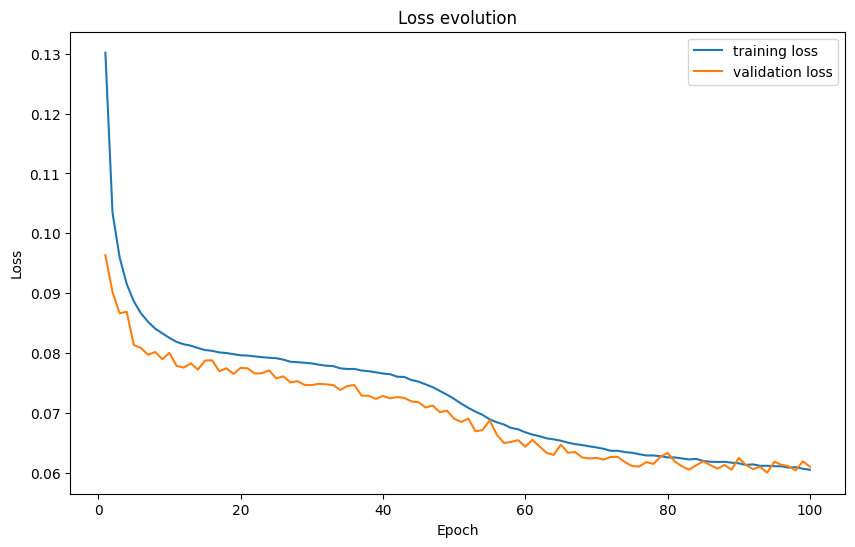

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best")
plt.show()

In [ ]:
# Prediction on test set
pred_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_lstm = test_data_keras_s
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])
results_lstm = scaler.inverse_transform(results_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_lstm"] = results_lstm[:,-1]

1097/1097 [==============================] - 3s 2ms/step


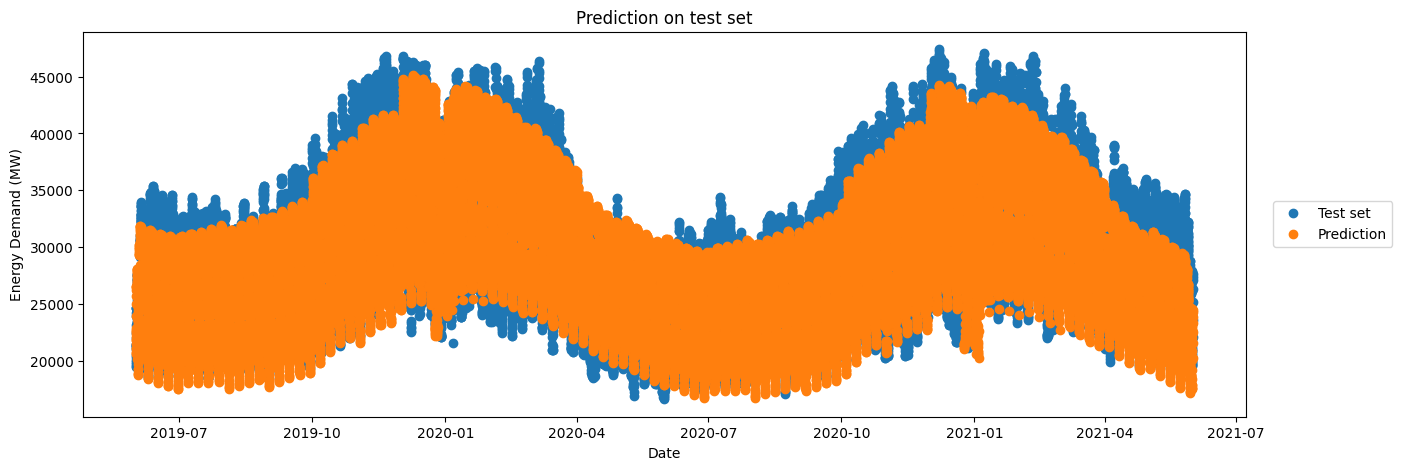

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

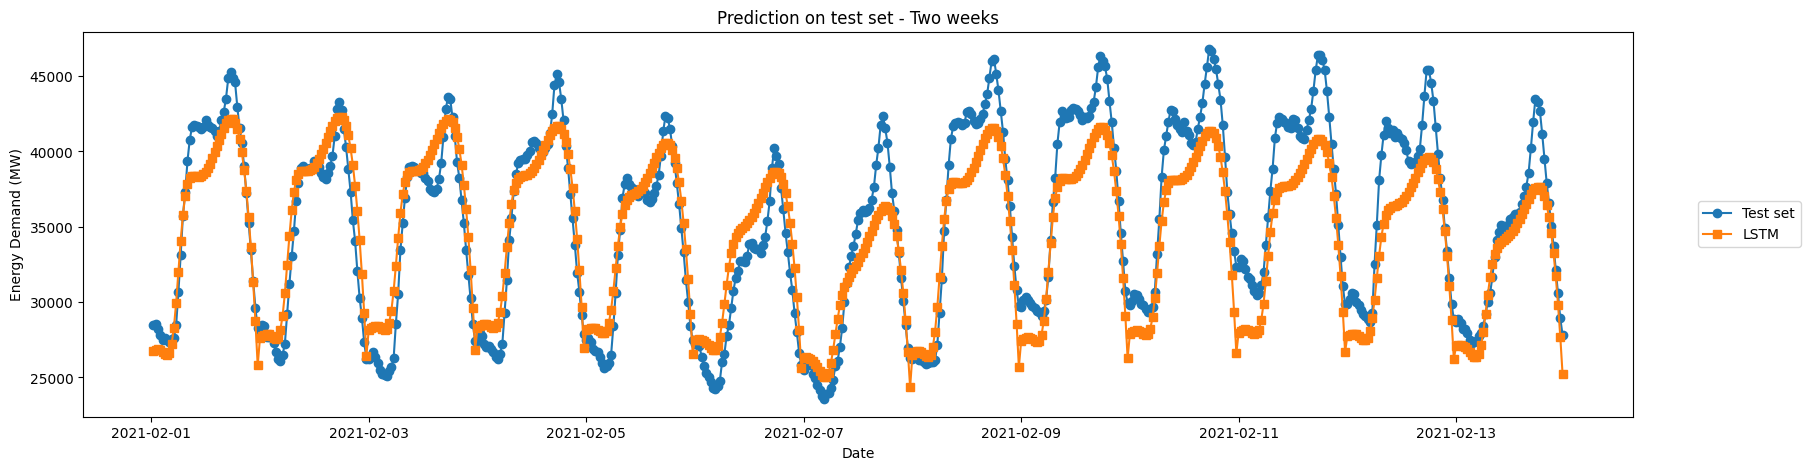

In [ ]:
begin = "2021-02-01"
end = "2021-02-14"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
mape_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_lstm"]
)

rmse_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_lstm"]))

print(
    "Mean Absolute Percentage Error of the LSTM model is: %.2f" % mape_lstm
)

print(
    "Root Mean Squared Error of the LSTM model is: %.2f MW" % rmse_lstm
)

Mean Absolute Percentage Error of the LSTM model is: 7.48
Root Mean Squared Error of the LSTM model is: 2737.58 MW


In [ ]:
# Create and compile neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Define callbacks
monitor_param = 'loss'
mode="min"
early_stopping = EarlyStopping(monitor='loss', patience=8, verbose=0, mode=mode)
checkpoint_save = ModelCheckpoint(
    "../models_data/deep_lstm/checkpoint",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history_deep_lstm = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss]
)

Epoch 1/100
1263/1263 [==============================] - 26s 11ms/step - loss: 0.1369 - val_loss: 0.0751 - lr: 0.0010
Epoch 2/100
1263/1263 [==============================] - 11s 8ms/step - loss: 0.0967 - val_loss: 0.0535 - lr: 0.0010
Epoch 3/100
1263/1263 [==============================] - 11s 8ms/step - loss: 0.0874 - val_loss: 0.0493 - lr: 0.0010
Epoch 4/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0811 - val_loss: 0.0369 - lr: 0.0010
Epoch 5/100
1263/1263 [==============================] - 9s 7ms/step - loss: 0.0747 - val_loss: 0.0339 - lr: 0.0010
Epoch 6/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0722 - val_loss: 0.0314 - lr: 0.0010
Epoch 7/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0708 - val_loss: 0.0296 - lr: 0.0010
Epoch 8/100
1263/1263 [==============================] - 10s 8ms/step - loss: 0.0699 - val_loss: 0.0290 - lr: 0.0010
Epoch 9/100
1263/1263 [==============================] - 10s 8ms

In [ ]:
# Prediction on test set
pred_deep_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm = test_data_keras_s
results_deep_lstm[:,-1] = pred_deep_lstm.reshape(pred_deep_lstm.shape[0])
results_deep_lstm = scaler.inverse_transform(results_deep_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_deep_lstm"] = results_deep_lstm[:,-1]

1097/1097 [==============================] - 4s 3ms/step


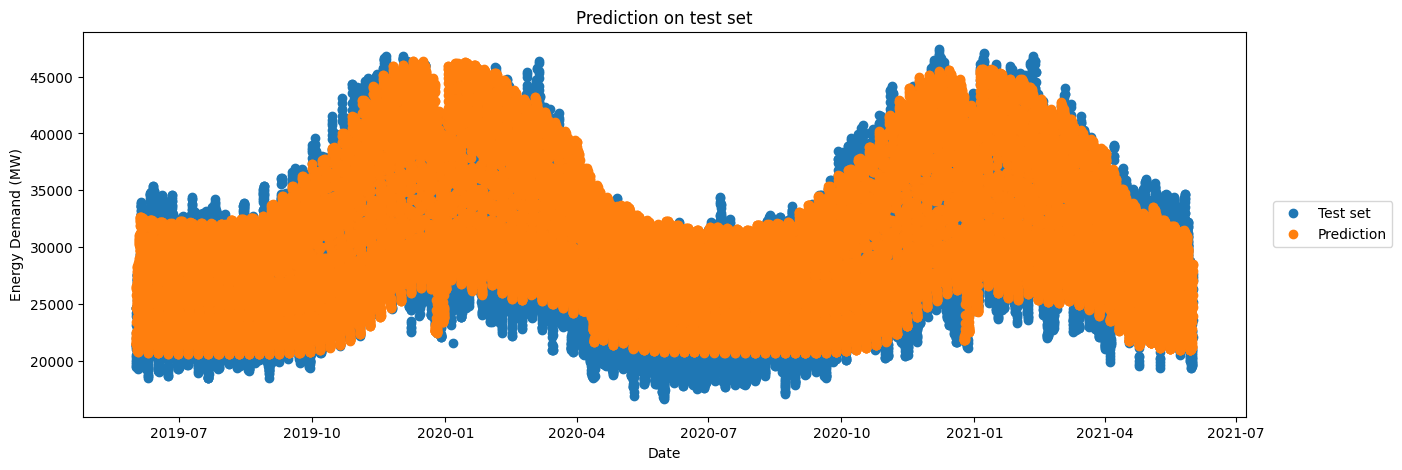

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_deep_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.show()

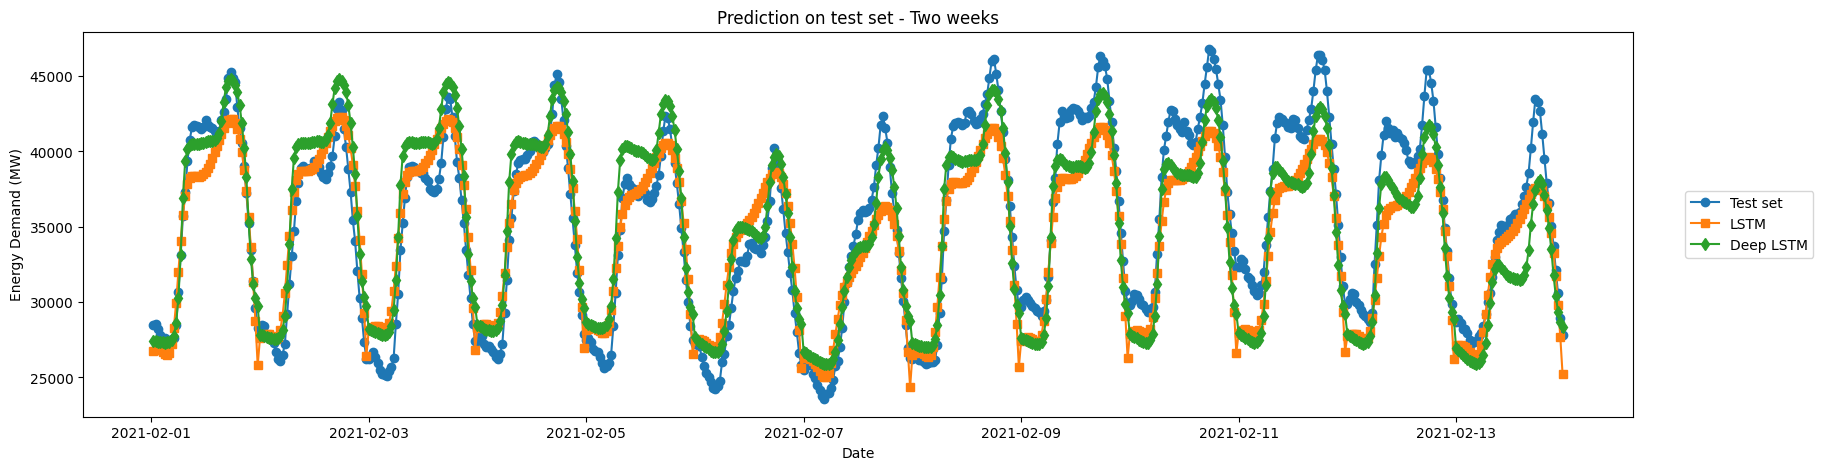

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_deep_lstm"
    ],
    "-d",
    label="Deep LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.show()

In [ ]:
mape_deep_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_deep_lstm"]
)

rmse_deep_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_deep_lstm"]))

print(
    "Mean Absolute Percentage Error of the deep LSTM model is: %.2f" % mape_deep_lstm
)

print(
    "Root Mean Squared Error of the deep LSTM model is: %.2f MW" % rmse_deep_lstm
)

Mean Absolute Percentage Error of the deep LSTM model is: 7.41
Root Mean Squared Error of the deep LSTM model is: 2638.06 MW


In [ ]:
summary_df = pd.DataFrame(
    {
        "XGBoost - Simple": [mape_xgboost_simple, rmse_xgboost_simple],
        "XGBoost - CV & GS": [mape_xgboost_cv, rmse_xgboost_cv],
        "Linear Boost": [mape_linear_boost, rmse_linear_boost],
        "Prophet - Simple": [mape_prophet_simple, rmse_prophet_simple],
        "Prophet - Holiday": [mape_prophet_holiday, rmse_prophet_holiday],
        "Prophet - CV & GS": [mape_prophet_cv_gs, rmse_prophet_cv_gs],
        "LSTM": [mape_lstm, rmse_lstm],
        "Deep LSTM": [mape_deep_lstm, rmse_deep_lstm],
        "Metric": ["MAPE", "RMSE"]
    }
)

summary_df.set_index("Metric", inplace=True)

summary_df.style.format('{:.2f}')